# Relative Representations for Cognitive Graphs

### SETUP

In [1]:
!pip install igraph
!pip install cairocffi
!pip install numba
!pip install inferactively-pymdp

  Using cached inferactively_pymdp-0.0.7.1-py3-none-any.whl (58 kB)
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached iniconfig-2.0.0-py3-none-any.whl (5.9 kB)
  Using cached py-1.11.0-py2.py3-none-any.whl (98 kB)
  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached XlsxWriter-3.1.2-py3-none-any.whl (153 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 1.3 MB/s eta 0:00:000:00:010:00:01:010m
  Using cached autograd-1.6.2-py3-none-any.whl (49 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 920.0 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 1.1 MB/s eta 0:00:000:00:01m eta 0:00:01
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
  Using cached nose-1.3.7-py3-none-any.whl (154 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached myst_nb-0.17.2-py3-none-any.whl (78 kB)
  Using cached futur

In [382]:
import os
import sys
import torch
import numpy as np
import numba as nb
import igraph
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

from tqdm import trange
from pymdp import maths, utils, control
from matplotlib import cm, colors
from sklearn.decomposition import PCA
from scipy.special import softmax
from scipy.spatial import distance
from scipy.stats import wasserstein_distance

In [3]:
#Pretty colors for plots
custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
        ]
    )
    / 256
)
if not os.path.exists("figures"):
    os.makedirs("figures")
if not os.path.exists("data"):
    os.makedirs("data")


In [207]:
custom_colors2 = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
            [155, 210, 170],
            [101, 101, 101],
            [175, 64, 100]
        ]
    )
    / 256
)
cmap2 = colors.ListedColormap(custom_colors2)

### Code (slightly modified) from [chmm_actions.py](https://github.com/vicariousinc/naturecomm_cscg/blob/main/chmm_actions.py) ###

In [202]:
def validate_seq(x, a, n_clones=None):
    """Validate an input sequence of observations x and actions a"""
    assert len(x) == len(a) > 0
    assert len(x.shape) == len(a.shape) == 1, "Flatten your array first"
    assert x.dtype == a.dtype == np.int64
    assert 0 <= x.min(), "Number of emissions inconsistent with training sequence"
    if n_clones is not None:
        assert len(n_clones.shape) == 1, "Flatten your array first"
        assert n_clones.dtype == np.int64
        assert all(
            [c > 0 for c in n_clones]
        ), "You can't provide zero clones for any emission"
        n_emissions = n_clones.shape[0]
        assert (
            x.max() < n_emissions
        ), "Number of emissions inconsistent with training sequence"


# Generate an (action, observation, ground-truth location) sequence given a room encoded as a grid of observations
# (And optionally, a pre-specified action sequence)
def datagen_structured_obs_room(
    room,
    start_r=None,
    start_c=None,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=10000,
    actions=None,
    seed=42,
):
    """room is a 2d numpy array. inaccessible locations are marked by -1.
    start_r, start_c: starting locations

    In addition, there are invisible obstructions in the room
    which disallows certain actions from certain states.

    no_left:
    no_right:
    no_up:
    no_down:

    Each of the above are list of states from which the corresponding action is not allowed.

    """
    if seed is not None:
        print("datagen obs room setting random seed")
        np.random.seed(seed)
    H, W = room.shape
    if start_r is None or start_c is None:
        start_r, start_c = np.random.randint(H), np.random.randint(W)

    if actions is not None:
        if length is not None:
            print("Warning: both `length` and `actions` params were supplied. Using length of action sequence.")
        length = len(actions)
    actions_taken = np.zeros(length, int)
    x = np.zeros(length, int)  # observations
    rc = np.zeros((length, 2), int)  # actual r&c

    r, c = start_r, start_c
    x[0] = room[r, c]
    rc[0] = r, c

    count = 0
    while count < length - 1:

        if actions is None:

            act_list = [0, 1, 2, 3]  # 0: left, 1: right, 2: up, 3: down
            if (r, c) in no_left:
                act_list.remove(0)
            if (r, c) in no_right:
                act_list.remove(1)
            if (r, c) in no_up:
                act_list.remove(2)
            if (r, c) in no_down:
                act_list.remove(3)

            a = np.random.choice(act_list)
        else:
            a = actions[count]

        # Check for actions taking out of the matrix boundary.
        prev_r = r
        prev_c = c
        if a == 0 and 0 < c:
            c -= 1
        elif a == 1 and c < W - 1:
            c += 1
        elif a == 2 and 0 < r:
            r -= 1
        elif a == 3 and r < H - 1:
            r += 1

        # Check whether action is taking to inaccessible states.
        temp_x = room[r, c]
        if temp_x == -1:
            r = prev_r
            c = prev_c
            pass

        actions_taken[count] = a            
        x[count + 1] = room[r, c]
        rc[count + 1] = r, c
        count += 1

    return actions_taken, x, rc


#### Functions to support main CSCG class

In [5]:
@nb.njit # Not sure if this is actually necessary/useful
def compute_p_obs(message, MAP=False):
    p_obs = message.max() if MAP else message.sum()
    assert p_obs > 0
    return p_obs, message / p_obs

@nb.njit
def forward(T_tr, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    ### 
    # `T_tr`: transition matrix with last 2 dims transposed - [action, to_state, from_state] 
    # `Pi`: Iniital state distribution
    # `n_clones`: vector of number of clones per possible observation
    # `x`: sequence of observations
    # `a`: sequence of actions/control states

    # Constructs a list of hidden state indices at which each clone group starts
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T_tr.dtype.type

    # Init log likelihood
    log2_lik = np.zeros(len(x), dtype)

    # forward pass

    # first timestep: use prior
    i = x[0]
    i_start, i_stop = state_loc[i:i + 2] 
    message = Pi[i_start:i_stop].copy().astype(dtype) # Leverage the fact that p(O|S) is 0 if S isn't in O's clones
    p_obs = message.sum() # Marginalize just over clones of observation - initial probs are p(clones)
    assert p_obs > 0
    message /= p_obs # Re-normalize message: p(obs|clones) = 1
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_loc = np.hstack(
            (np.array([0], dtype=n_clones.dtype), n_clones[x])
        ).cumsum()
        mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
        t_start, t_stop = mess_loc[:2]
        mess_fwd[t_start:t_stop] = message
    else:
        mess_fwd = None
    # Recursively compute probs for subsequent timesteps using transition matrix
    for t in range(1, x.shape[0]):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        message = np.ascontiguousarray(T_tr[aij, j_start:j_stop, i_start:i_stop]).dot(
            message
        )
        p_obs = message.sum()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            t_start, t_stop = mess_loc[t : t + 2]
            mess_fwd[t_start:t_stop] = message
    return log2_lik, mess_fwd


def forwardE(T_tr, E, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    # `E`: 'Emission probabilities' (likelihood matrix)
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    message = Pi * E[:, j]
    p_obs, message = compute_p_obs(message)
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
        mess_fwd[t] = message
    for t in range(1, x.shape[0]):
        aij, j = (
            a[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j

        message = T_tr[aij].dot(message)
        message *= E[:, j]

        p_obs, message = compute_p_obs(message)
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            mess_fwd[t] = message
    if store_messages:
        return log2_lik, mess_fwd
    else:
        return log2_lik


@nb.njit
def forward_mp(T_tr, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    ### Version of forward pass used for max-product message passing / MAP inference of latents
    # The difference to `forward` is just that rather than marginalizing over clones to get p(obs) we 
    # take the max likelihood clone
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    j_start, j_stop = state_loc[j : j + 2]
    message = Pi[j_start:j_stop].copy().astype(dtype)

    p_obs = message.max()
    assert p_obs > 0
    message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_loc = np.hstack(
            (np.array([0], dtype=n_clones.dtype), n_clones[x])
        ).cumsum()
        mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
        t_start, t_stop = mess_loc[t : t + 2]
        mess_fwd[t_start:t_stop] = message
    else:
        mess_fwd = None

    for t in range(1, x.shape[0]):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        new_message = np.zeros(j_stop - j_start, dtype=dtype)
        for d in range(len(new_message)):
            new_message[d] = (T_tr[aij, j_start + d, i_start:i_stop] * message).max()        
        message = new_message
        p_obs = message.max()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            t_start, t_stop = mess_loc[t : t + 2]
            mess_fwd[t_start:t_stop] = message
    return log2_lik, mess_fwd
  

def forwardE_mp(T_tr, E, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    message = Pi * E[:, j]
    p_obs, message = compute_p_obs(message, MAP=True)

    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
        mess_fwd[t] = message
    for t in range(1, x.shape[0]):
        aij, j = (
            a[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        message = (T_tr[aij] * message.reshape(1, -1)).max(1)
        message *= E[:, j]
        p_obs, message = compute_p_obs(message, MAP=True)
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            mess_fwd[t] = message
    if store_messages:
        return log2_lik, mess_fwd
    else:
        return log2_lik


def forward_mp_all(T_tr, Pi_x, Pi_a, n_clones, target_state, max_steps):
    """Log-probability of a sequence, and optionally, messages"""
    # Compute likelihood using all hidden states, not just clones of observation
    # forward pass
    t, log2_lik = 0, []
    message = Pi_x
    p_obs, message = compute_p_obs(message, MAP=True)
    log2_lik.append(np.log2(p_obs))
    mess_fwd = []
    mess_fwd.append(message)
    T_tr_maxa = (T_tr * Pi_a.reshape(-1, 1, 1)).max(0)
    for t in range(1, max_steps):
        message = (T_tr_maxa * message.reshape(1, -1)).max(1)
        p_obs, message = compute_p_obs(message, MAP=True)
        log2_lik.append(np.log2(p_obs))
        mess_fwd.append(message)
        if message[target_state] > 0:
            break
    else:
        assert False, "Unable to find a bridging path"
    return np.array(log2_lik), np.array(mess_fwd)


##### Backward message passing / state inference

In [6]:
@nb.njit
def rargmax(x):
    # return x.argmax()  # <- favors clustering towards smaller state numbers
    return np.random.choice((x == x.max()).nonzero()[0])


@nb.njit
def backtrace(T, n_clones, x, a, mess_fwd):
    """Compute backward messages."""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    code = np.zeros(x.shape[0], dtype=np.int64)

    # backward pass
    t = x.shape[0] - 1
    i = x[t]
    t_start, t_stop = mess_loc[t : t + 2]
    belief = mess_fwd[t_start:t_stop]
    code[t] = rargmax(belief)
    for t in range(x.shape[0] - 2, -1, -1):
        aij, i, j = (
            a[t],
            x[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        (i_start, i_stop), j_start = state_loc[i : i + 2], state_loc[j]
        t_start, t_stop = mess_loc[t : t + 2]
        belief = (
            mess_fwd[t_start:t_stop] * T[aij, i_start:i_stop, j_start + code[t + 1]]
        )
        code[t] = rargmax(belief)
    states = state_loc[x] + code
    return states
    

def backwardE(T, E, n_clones, x, a):
    """Compute backward messages."""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T.dtype.type

    # backward pass
    t = x.shape[0] - 1
    message = np.ones(E.shape[0], dtype)
    message /= message.sum()
    mess_bwd = np.empty((len(x), E.shape[0]), dtype=dtype)
    mess_bwd[t] = message
    for t in range(x.shape[0] - 2, -1, -1):
        aij, j = (
            a[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        message = T[aij].dot(message * E[:, j])
        p_obs, message = compute_p_obs(message)
        mess_bwd[t] = message
    return mess_bwd


def backtraceE(T, E, n_clones, x, a, mess_fwd):
    """Compute backward messages."""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    states = np.zeros(x.shape[0], dtype=np.int64)

    # backward pass
    t = x.shape[0] - 1
    belief = mess_fwd[t]
    states[t] = rargmax(belief)
    for t in range(x.shape[0] - 2, -1, -1):
        aij = a[t]  # at time t -> t+1 we go from observation i to observation j
        belief = mess_fwd[t] * T[aij, :, states[t + 1]]
        states[t] = rargmax(belief)
    return states


@nb.njit
def backward(T, n_clones, x, a):
    """Compute backward messages."""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T.dtype.type

    # backward pass
    t = x.shape[0] - 1
    i = x[t]
    message = np.ones(n_clones[i], dtype) / n_clones[i]
    message /= message.sum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    mess_bwd = np.empty(mess_loc[-1], dtype)
    t_start, t_stop = mess_loc[t : t + 2]
    mess_bwd[t_start:t_stop] = message
    for t in range(x.shape[0] - 2, -1, -1):
        aij, i, j = (
            a[t],
            x[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        message = np.ascontiguousarray(T[aij, i_start:i_stop, j_start:j_stop]).dot(
            message
        )
        p_obs, message = compute_p_obs(message)
        t_start, t_stop = mess_loc[t : t + 2]
        mess_bwd[t_start:t_stop] = message
    return mess_bwd


def backtrace_all(T, Pi_a, n_clones, mess_fwd, target_state):
    """Compute backward messages."""
    states = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    actions = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    n_states = T.shape[1]
    # backward pass
    t = mess_fwd.shape[0] - 1
    actions[t], states[t] = (
        -1,
        target_state,
    )  # last actions is irrelevant, use an invalid value
    for t in range(mess_fwd.shape[0] - 2, -1, -1):
        belief = (
            mess_fwd[t].reshape(1, -1) * T[:, :, states[t + 1]] * Pi_a.reshape(-1, 1)
        )
        a_s = rargmax(belief.flatten())
        actions[t], states[t] = a_s // n_states, a_s % n_states
    return actions, states


##### Update transition matrix

In [7]:
@nb.njit
def updateC(C, T, n_clones, mess_fwd, mess_bwd, x, a):
    # Reset / update pseudocounts matrix
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    timesteps = len(x)
    C[:] = 0
    for t in range(1, timesteps):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (tm1_start, tm1_stop), (t_start, t_stop) = (
            mess_loc[t - 1 : t + 1],
            mess_loc[t : t + 2],
        )
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        # Compute unnormalized variational density(?) as product of transition matrix, forward and backward messages
        q = (
            mess_fwd[tm1_start:tm1_stop].reshape(-1, 1)
            * T[aij, i_start:i_stop, j_start:j_stop]
            * mess_bwd[t_start:t_stop].reshape(1, -1)
        )
        q /= q.sum()
        # Treating probabilities over hidden states as "soft" aggregated states for pseudocount update
        C[aij, i_start:i_stop, j_start:j_stop] += q
        

def updateCE(CE, E, n_clones, mess_fwd, mess_bwd, x, a):
    timesteps = len(x)
    gamma = mess_fwd * mess_bwd
    norm = gamma.sum(1, keepdims=True)
    norm[norm == 0] = 1
    gamma /= norm
    CE[:] = 0
    for t in range(timesteps):
        CE[:, x[t]] += gamma[t]


#### Main CHMM (CSCG) class

In [8]:
def plot_graph(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30, n_clones=70
):
    states = chmm.decode(x, a)[1]
  
    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out


def get_mess_fwd(chmm, x, a=None, pseudocount=0.0, pseudocount_E=0.0):
    n_clones = chmm.n_clones
    E = np.zeros((n_clones.sum(), len(n_clones)))
    last = 0
    for c in range(len(n_clones)):
        E[last : last + n_clones[c], c] = 1
        last += n_clones[c]
    E += pseudocount_E
    norm = E.sum(1, keepdims=True)
    norm[norm == 0] = 1
    E /= norm
    T = chmm.C + pseudocount
    norm = T.sum(2, keepdims=True)
    norm[norm == 0] = 1
    T /= norm
    if a is None:
        T = T.mean(0, keepdims=True)
        a = x * 0
    log2_lik, mess_fwd = forwardE(
        T.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, a, store_messages=True
    )
    return mess_fwd


def place_field(mess_fwd, rc, clone):
    assert mess_fwd.shape[0] == rc.shape[0] and clone < mess_fwd.shape[1]
    field = np.zeros(rc.max(0) + 1)
    count = np.zeros(rc.max(0) + 1, int)
    for t in range(mess_fwd.shape[0]):
        r, c = rc[t]
        field[r, c] += mess_fwd[t, clone]
        count[r, c] += 1
    count[count == 0] = 1
    return field / count


In [201]:
class CHMM(object):
    def __init__(self, n_clones, x, a, pseudocount=0.0, dtype=np.float32, seed=42):
        """Construct a CHMM objct. n_clones is an array where n_clones[i] is the
        number of clones assigned to observation i. x and a are the observation sequences
        and action sequences, respectively."""
        # pseudocount: smoothing factor
        if seed is not None:
            print("CHMM setting random seed")
            np.random.seed(seed)
        self.n_clones = n_clones
        self.state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
        validate_seq(x, a, self.n_clones)
        assert pseudocount >= 0.0, "The pseudocount should be positive"
        print("Average number of clones:", n_clones.mean())
        self.pseudocount = pseudocount
        self.dtype = dtype
        n_states = self.n_clones.sum()
        n_actions = a.max() + 1

        # Random init of counts matrix (for updating transition probs)
        self.C = np.random.rand(n_actions, n_states, n_states).astype(dtype)
        
        # Flat distributions over states and actions
        self.Pi_x = np.ones(n_states) / n_states
        self.Pi_a = np.ones(n_actions) / n_actions

        # Create initial transition matrix (by normalizing random counts)
        self.update_T()

    def update_T(self):
        """Update the transition matrix given the accumulated counts matrix."""
        self.T = self.C + self.pseudocount
        norm = self.T.sum(2, keepdims=True)
        norm[norm == 0] = 1 # Not sure I get this
        self.T /= norm

    def update_E(self, CE):
        """Update the emission matrix.""" # Likelihood
        E = CE + self.pseudocount
        norm = E.sum(1, keepdims=True)
        norm[norm == 0] = 1
        E /= norm
        return E

    def bps(self, x, a):
        """Compute the log likelihood (log base 2) of a sequence of observations and actions."""
        validate_seq(x, a, self.n_clones)
        log2_lik = forward(self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a)[0]
        return -log2_lik

    def bpsE(self, E, x, a):
        """Compute the log likelihood using an alternate emission matrix."""
        validate_seq(x, a, self.n_clones)
        log2_lik = forwardE(
            self.T.transpose(0, 2, 1), E, self.Pi_x, self.n_clones, x, a
        )
        return -log2_lik

    def bpsV(self, x, a):
        validate_seq(x, a, self.n_clones)
        log2_lik = forward_mp(
            self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a
        )[0]
        return -log2_lik

    def decode(self, x, a):
        """Compute the MAP assignment of latent variables using max-product message passing."""
        log2_lik, mess_fwd = forward_mp(
            self.T.transpose(0, 2, 1),
            self.Pi_x,
            self.n_clones,
            x,
            a,
            store_messages=True,
        )
        states = backtrace(self.T, self.n_clones, x, a, mess_fwd)
        return -log2_lik, states

    def decodeE(self, E, x, a):
        """Compute the MAP assignment of latent variables using max-product message passing
        with an alternative emission matrix."""
        log2_lik, mess_fwd = forwardE_mp(
            self.T.transpose(0, 2, 1),
            E,
            self.Pi_x,
            self.n_clones,
            x,
            a,
            store_messages=True,
        )
        states = backtraceE(self.T, E, self.n_clones, x, a, mess_fwd)
        return -log2_lik, states

    def learn_em_T(self, x, a, n_iter=100, term_early=True, save_every=None):
        """Run EM training, keeping E deterministic and fixed, learning T"""
        sys.stdout.flush()
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E

            # Forward pass: entire [observation, action] sequence at once
            log2_lik, mess_fwd = forward(
                self.T.transpose(0, 2, 1),
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            mess_bwd = backward(self.T, self.n_clones, x, a)
            # Update pseudocounts, using transition matrix, forward and backward messages and sequence
            updateC(self.C, self.T, self.n_clones, mess_fwd, mess_bwd, x, a)
            # M
            self.update_T()
            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                if term_early:
                    break
            log2_lik_old = log2_lik.mean()

            if save_every is not None and it % save_every == 0:
                np.save("data/transitions2", self.T)
        return convergence

    def learn_viterbi_T(self, x, a, n_iter=100, save_every=None):
        """Run Viterbi training, keeping E deterministic and fixed, learning T"""
        sys.stdout.flush()
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E - (Diff from EM: `forawrd_mp`; uses max prob instead of marginalizing)
            log2_lik, mess_fwd = forward_mp(
                self.T.transpose(0, 2, 1),
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            # This returns a maximum a posteriori estimate of the hidden sequence, given obs sequence
            states = backtrace(self.T, self.n_clones, x, a, mess_fwd) 
            # Update count/transition matrices to make inferred hidden sequence more likely
            self.C[:] = 0
            for t in range(1, len(x)):
                aij, i, j = (
                    a[t - 1],
                    states[t - 1],
                    states[t],
                )  # at time t-1 -> t we go from observation i to observation j
                self.C[aij, i, j] += 1.0
            # M
            self.update_T()
            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                pass #break
            log2_lik_old = log2_lik.mean()

            if save_every is not None and it % save_every == 0:
                np.save("data/transitions", self.T)
        return convergence

    def learn_em_E(self, x, a, n_iter=100, pseudocount_extra=1e-20):
        """Run Viterbi training, keeping T fixed, learning E"""
        sys.stdout.flush()
        n_emissions, n_states = len(self.n_clones), self.n_clones.sum()
        CE = np.ones((n_states, n_emissions), self.dtype)
        E = self.update_E(CE + pseudocount_extra)
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E
            log2_lik, mess_fwd = forwardE(
                self.T.transpose(0, 2, 1),
                E,
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            mess_bwd = backwardE(self.T, E, self.n_clones, x, a)
            updateCE(CE, E, self.n_clones, mess_fwd, mess_bwd, x, a)
            # M
            E = self.update_E(CE + pseudocount_extra)
            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                break
            log2_lik_old = log2_lik.mean()
        return convergence, E

    def sample(self, length):
        """Sample from the CHMM."""
        assert length > 0
        state_loc = np.hstack(([0], self.n_clones)).cumsum(0)
        sample_x = np.zeros(length, dtype=np.int64)
        sample_a = np.random.choice(len(self.Pi_a), size=length, p=self.Pi_a)

        # Sample
        p_h = self.Pi_x
        for t in range(length):
            h = np.random.choice(len(p_h), p=p_h)
            sample_x[t] = np.digitize(h, state_loc) - 1
            p_h = self.T[sample_a[t], h]
        return sample_x, sample_a

    def sample_sym(self, sym, length):
        """Sample from the CHMM conditioning on an inital observation."""
        # Prepare structures
        assert length > 0
        state_loc = np.hstack(([0], self.n_clones)).cumsum(0)

        seq = [sym]

        alpha = np.ones(self.n_clones[sym])
        alpha /= alpha.sum()

        for _ in range(length):
            obs_tm1 = seq[-1]
            T_weighted = self.T.sum(0)

            long_alpha = np.dot(
                alpha, T_weighted[state_loc[obs_tm1] : state_loc[obs_tm1 + 1], :]
            )
            long_alpha /= long_alpha.sum()
            idx = np.random.choice(np.arange(self.n_clones.sum()), p=long_alpha)

            sym = np.digitize(idx, state_loc) - 1
            seq.append(sym)

            temp_alpha = long_alpha[state_loc[sym] : state_loc[sym + 1]]
            temp_alpha /= temp_alpha.sum()
            alpha = temp_alpha

        return seq

    def bridge(self, state1, state2, max_steps=100):
        Pi_x = np.zeros(self.n_clones.sum(), dtype=self.dtype)
        Pi_x[state1] = 1
        log2_lik, mess_fwd = forward_mp_all(
            self.T.transpose(0, 2, 1), Pi_x, self.Pi_a, self.n_clones, state2, max_steps
        )
        s_a = backtrace_all(self.T, self.Pi_a, self.n_clones, mess_fwd, state2)
        return s_a

# Cosine similarity

In [521]:
_cosine_sim = torch.nn.CosineSimilarity()

def cosine_sim(a, b, dim=1, log_transform=False):
    cs = _cosine_sim if dim in [1, None] else torch.nn.CosineSimilarity(dim=dim)
        
    if type(a) != torch.Tensor:
        a = torch.Tensor(a)
    if type(b) != torch.Tensor:
        b = torch.Tensor(b)
    
    if log_transform:
        a, b = torch.log(a + 1e-12), torch.log(b + 1e-12)
    
    if dim is None and len(a.shape) > 1:
        return torch.squeeze(torch.cat([_cosine_sim(ai, b).unsqueeze(0) for ai in a]))   

    return cs(a, b)


def jensen_shannon_dist(a, b, dim=None):
    
    if type(a) != torch.Tensor:
        a = torch.Tensor(a)
    if type(b) != torch.Tensor:
        b = torch.Tensor(b)
    
    if dim is None and len(a.shape) > 1:
        return torch.squeeze(torch.cat([torch.Tensor(distance.jensenshannon(ai, b, axis=-1)).unsqueeze(0) for ai in a]))   

    return distance.jensenshannon(a, b, axis=dim)

def _get_samples(probs, N=1000):
    # Get around annoying rounding issue
    probs = probs.astype('float64')
    probs /= sum(probs)
    return np.random.multinomial(N, probs)

def wasserstein_dist(a, b):
    # Assumes a and b are both [batch_size x embedding_size] arrays
    
    if type(a) == torch.Tensor:
        a = a.numpy()
    if type(b) == torch.Tensor:
        b = b.numpy()
    
    if len(a.shape) == 1:
        a = np.expand_dims(a, 0)
    
    if len(b.shape) == 1:
        b = np.expand_dims(b, 0)
    
    result = np.empty((a.shape[0], b.shape[0]))
                
    for i in range(a.shape[0]):
        a_samples = _get_samples(a[i])
        for j in range(len(b)):
            b_samples = _get_samples(b[i])
            result[i, j] = wasserstein_distance(a_samples, b_samples)
    
    return torch.Tensor(result)


# Random gen

In [291]:
def random_room(dims: tuple=(6,8), num_obs: int=4, visualize=True):
    x, y = dims
    room = np.random.choice(num_obs, x*y).reshape(dims)
    
    if visualize:
        cmap = colors.ListedColormap(custom_colors[-4:])
        plt.matshow(room, cmap=cmap)

    return room

def random_walk(room: np.array, length:int=5000, seed:int=None, actions=None, start_r=None, start_c=None):
    return datagen_structured_obs_room(room, length=length, seed=seed, actions=actions, start_r=start_r, start_c=start_c)
    
def get_nclones(room: np.array, clones_per_obs:int = 70):
    n_emissions = room.max() + 1
    return np.ones(n_emissions, dtype=np.int64) * clones_per_obs


# Model sharing

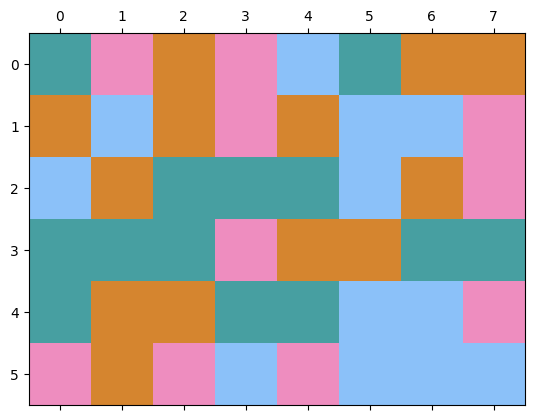

In [22]:
room = random_room()

a, x, rc = random_walk(room)
a2, x2, rc2 = random_walk(room)


In [23]:
n_clones = get_nclones(room)

chmm1 = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=None)  # Initialize the model
progression = chmm1.learn_em_T(x, a, n_iter=1000)  # Training

chmm2 = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x2, a=a2, seed=None)  # Initialize the model
progression2 = chmm2.learn_em_T(x2, a2, n_iter=1000)  # Training

Average number of clones: 70.0


 15%|███▎                   | 146/1000 [00:16<01:33,  9.12it/s, train_bps=0.032]

Average number of clones: 70.0



 19%|████▍                  | 191/1000 [00:21<01:29,  9.05it/s, train_bps=0.032]


In [24]:
# refine learning
chmm1.pseudocount = 0.0
v_prog = chmm1.learn_viterbi_T(x, a, n_iter=100)

chmm2.pseudocount = 0.0
v_prog2 = chmm2.learn_viterbi_T(x2, a2, n_iter=100)

100%|██████████████████████| 100/100 [00:10<00:00,  9.55it/s, train_bps=0.00163]


# Compare learned maps

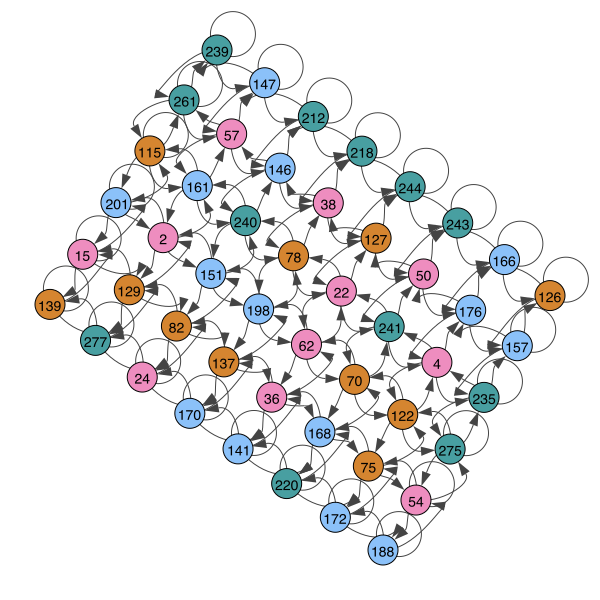

In [25]:
graph = plot_graph(
    chmm1, x, a, output_file="figures/chmm1_rectangular_room_graph.pdf", cmap=cmap
)
graph


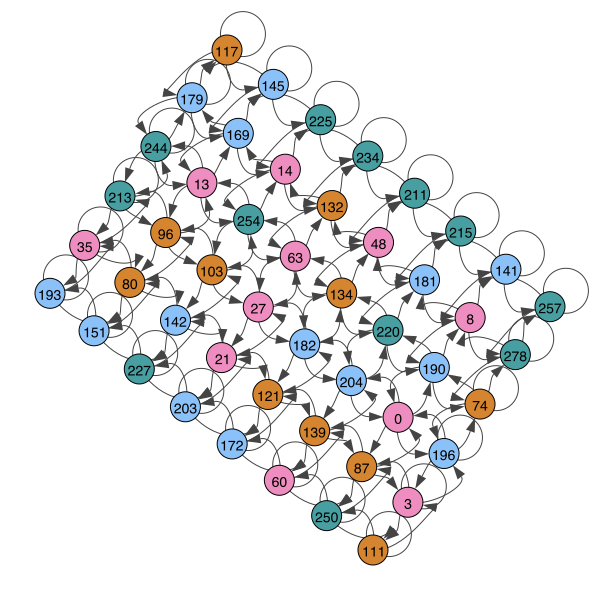

In [26]:
graph = plot_graph(
    chmm2, x2, a2, output_file="figures/chmm2_rectangular_room_graph.pdf", cmap=cmap
)
graph


In [27]:
# Get forward messages for a sequence
mess_fwd_chmm1 = get_mess_fwd(chmm1, x, pseudocount_E=0.1)
mess_fwd_chmm2 = get_mess_fwd(chmm2, x, pseudocount_E=0.1)

mess_fwd_chmm1_actions = get_mess_fwd(chmm1, x, a, pseudocount_E=0.1)
mess_fwd_chmm2_actions = get_mess_fwd(chmm2, x, a, pseudocount_E=0.1)

mess_fwd_chmm1x2 = get_mess_fwd(chmm1, x2, pseudocount_E=0.1)
mess_fwd_chmm2x2 = get_mess_fwd(chmm2, x2, pseudocount_E=0.1)

mess_fwd_chmm1x2_actions = get_mess_fwd(chmm1, x2, a2, pseudocount_E=0.1)
mess_fwd_chmm2x2_actions = get_mess_fwd(chmm2, x2, a2, pseudocount_E=0.1)

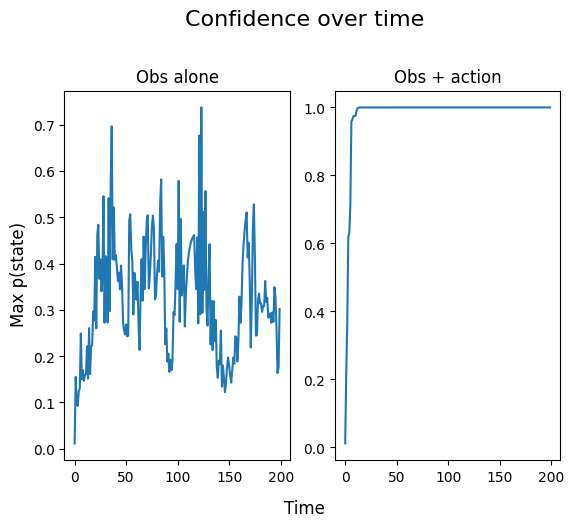

In [ ]:
# Plot certainty over time

fig, (ax1, ax2) = plt.subplots(1,2)

num_steps = 200

sequence = mess_fwd_chmm1[:num_steps]
sequence_actions = mess_fwd_chmm1_actions[:num_steps]

fig.suptitle('Confidence over time', fontsize=16, y=1.05)
ax1.plot(
    range(num_steps),
    np.max(sequence, axis=1)
)
_ = ax1.set_title("Obs alone")
ax2.plot(
    range(num_steps),
    np.max(sequence_actions, axis=1)
)
_ = ax2.set_title("Obs + action")

fig.text(0.5, 0.0, 'Time', ha='center', fontsize=12)
_ = fig.text(0.04, 0.5, 'Max p(state)', va='center', rotation='vertical', fontsize=12)


In [ ]:
# Average cosine similarity
avg_cs = torch.mean(cosine_sim(mess_fwd_chmm1, mess_fwd_chmm2))
print("Average cosine similarity across CHMM1 and CHMM2 messages:", avg_cs)

# Permuted cosine similarity
chmm1_mess_fwd_permuted = [sorted(t) for t in mess_fwd_chmm1]
chmm2_mess_fwd_permuted = [sorted(t) for t in mess_fwd_chmm2]

avg_cs_permuted = torch.mean(cosine_sim(chmm1_mess_fwd_permuted, chmm2_mess_fwd_permuted))
print("Average cosine similarity across CHMM1 and CHMM2 messages (sorted):", avg_cs_permuted)

Average cosine similarity across CHMM1 and CHMM2 messages: tensor(0.0848)
Average cosine similarity across CHMM1 and CHMM2 messages (sorted): tensor(1.)


In [19]:
# Construct a map
chmm1_sorted_indices = np.argsort(mess_fwd_chmm1)[-1]
chmm2_sorted_indices = np.argsort(mess_fwd_chmm2)[-1]

state_map = {s1: s2 for (s1, s2) in zip(chmm1_sorted_indices, chmm2_sorted_indices)}

state_idx = 45
print(f"CHMM2 state corresponding to state {state_idx} in CHMM1: {state_map[state_idx]}")

state_idx = 119
print(f"CHMM2 state corresponding to state {state_idx} in CHMM1: {state_map[state_idx]}")

CHMM2 state corresponding to state 45 in CHMM1: 73
CHMM2 state corresponding to state 119 in CHMM1: 106


In [20]:
# Reconstruct using map

def reconstruct_state(input_mess, target_mess, state_map):
    return np.array([target_mess[state_map[s]] for s in range(len(input_mess))])

chmm2_recon_perm = np.array(
    [
        np.array([reconstruct_state(s1, s2, state_map) for (s1, s2) in zip(mess_fwd_chmm1, mess_fwd_chmm2)])    
    ]
)

print("Reconstruction using permutations: ", torch.mean(cosine_sim(mess_fwd_chmm2, chmm2_recon_perm)))


Reconstruction using permutations:  tensor(0.6822)


# Create Relative Representations

In [396]:
def get_anchor_rrs(anchors):
    '''Get "relative anchors" i.e. relative representations for each anchor point
    (For use in deriving weights to reconstruct absolute representations)
    '''
    return cosine_sim(anchors, anchors, dim=None) 


class Metric(Enum):
    CosineSim = "cosine_sim"
    JensenShannon = "jensen-shannon"
    Jaccard = "jaccard"

def reconstruct(Z, anchors, target_anchors, metric='cosine_sim', return_softmax=False, softmax_temp=0.01):
    rr = get_RR(Z, anchors, metric=metric)
    weights = softmax(rr/softmax_temp, axis=-1)
    recon = np.dot(weights, target_anchors)
    if return_softmax:
        return softmax(recon/softmax_temp)    
    return recon


def get_RR(X, anchors, metric='cosine_sim'):
    if metric == 'cosine_sim':
        return cosine_sim(X, anchors, dim=None)
    elif metric == 'log_cosine':
        return cosine_sim(X, anchors, dim=None, log_transform=True)
    elif metric == 'jaccard':
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        min = np.sum(np.array([np.minimum(x, anchors) for x in X]), axis=-1)
        max = np.sum(np.array([np.maximum(x, anchors) for x in X]), axis=-1)
        return min / max
    elif metric == 'jensen-shannon':
        return -jensen_shannon_dist(X, anchors, dim=None)
    elif metric == 'wasserstein':
        return -wasserstein_dist(X, anchors)
        
    else:
      raise ValueError("`metric` must be 'cosine_sim', 'jaccard', 'log_cosine', 'wasserstein', or 'jensen-shannon'")


def add_anchors(model_list:list[CHMM], x_list, a_list=None, pseudocount_E=0.1, num_anchors=1000, permute=True, filter=[None, None]):
    if type(x_list) != list:
        x_list = [x_list] * len(model_list)
    if type(a_list) != list:
        a_list = [a_list] * len(model_list)
    if num_anchors is not None:
        anchor_idxs = np.random.choice(len(x_list[0]), num_anchors, replace=False)
    else:
        anchor_idxs = slice(0, None, None)
        num_anchors = len(x_list[0])
    if permute:
        permutation = np.random.permutation(list(range(num_anchors)))
    for idx, model in enumerate(model_list):
        x = x_list[idx]
        a = a_list[idx] if a_list is not None else None
        mess_fwd = get_mess_fwd(model, x, a, pseudocount_E=pseudocount_E)
        anchors = mess_fwd[anchor_idxs]
        if permute:
            anchors = anchors[permutation]
        model.mess_fwd = torch.Tensor(mess_fwd)
        model.anchors = anchors

    return model_list


In [255]:
chmm1, chmm2 = add_anchors([chmm1, chmm2], x, num_anchors=5000)

In [274]:
cosine_sim(chmm1.anchors, chmm2.anchors, dim=None).shape

torch.Size([5000, 5000])

In [402]:
cosine_sim(chmm1.anchors[0], chmm2.anchors, dim=None, log_transform=True)

tensor([0.8908, 0.8921, 0.8905,  ..., 0.8925, 0.8897, 0.8855])

In [287]:
# [distance.jensenshannon(x, chmm2.anchors, axis=-1) for x in chmm1.anchors].shape

jensen_shannon_sim(chmm1.anchors, chmm2.anchors, dim=None).shape

torch.Size([5000, 5000])

In [449]:
g = torch.Tensor(chmm1.anchors[-1]).to(torch.float64)
print(sum(g))

tensor(1.0000, dtype=torch.float64)


In [ ]:
wasserstein_dist(chmm1.anchors, chmm2.anchors)

In [294]:
test_mess_fwd_model1 = get_mess_fwd(chmm1, x, pseudocount_E=0.1)

In [319]:
k = reconstruct(
        test_mess_fwd_model1, 
        chmm1.anchors, 
        chmm2.anchors, 
        metric="jensen-shannon",
        return_softmax=False
)

(5000, 280)
(5000, 280)


In [321]:
print(get_RR(test_mess_fwd_model1, chmm2.anchors).shape)
print(get_RR(test_mess_fwd_model1, chmm2.anchors, metric="jensen-shannon").shape)

torch.Size([5000, 5000])
(5000, 280)
(5000, 280)
torch.Size([5000, 5000])


In [519]:
m10recon = reconstruct(test_mess_fwd_model1[-1], chmm1.anchors, chmm2.anchors, metric="wasserstein")

In [520]:
cosine_sim(m10recon, test_mess_fwd_model1[-1])

tensor([0.0017])

# Experiments

In [297]:
# Helpers

from enum import Enum
import pandas as pd
import time


def random_room(dims: tuple=(6,8), num_obs: int=4, visualize=True):
    x, y = dims
    room = np.random.choice(num_obs, x*y).reshape(dims)
    
    if visualize:
        cmap = colors.ListedColormap(custom_colors[-4:])
        plt.matshow(room, cmap=cmap)

    return room

def random_walk(room: np.array, length:int=5000, seed:int=None, actions=None, start_r=None, start_c=None):
    return datagen_structured_obs_room(room, length=length, seed=seed, actions=actions, start_r=start_r, start_c=start_c)
    
def get_nclones(room: np.array, clones_per_obs:int = 70):
    n_emissions = room.max() + 1
    return np.ones(n_emissions, dtype=np.int64) * clones_per_obs

def train_CSCG(x: np.array, a: np.array, n_clones:int, pseudocount:float=2e-3, seed=None, n_iter_bw=1000, n_iter_viterbi=100):
    chmm = CHMM(n_clones=n_clones, pseudocount=pseudocount, x=x, a=a, seed=seed)
    progression = chmm.learn_em_T(x, a, n_iter=n_iter_bw)
    chmm1.pseudocount = 0.0
    v_prog = chmm.learn_viterbi_T(x, a, n_iter=n_iter_viterbi)
                
    return chmm, progression, v_prog
                
def get_state_map(mess_fwd1: np.array, mess_fwd2: np.array):
    sorted_indices1 = np.argsort(mess_fwd1)[-1]
    sorted_indices2 = np.argsort(mess_fwd2)[-1]

    return {s1: s2 for (s1, s2) in zip(sorted_indices1, sorted_indices2)}

def reconstruct_using_permutations(input_mess, target_mess, state_map):
    return np.array([target_mess[state_map[s]] for s in range(len(input_mess))])

class Condition(Enum):
    Identical = "Identical"
    Expansion = "Expansion"
    Isomorphic = "Isomorphic"
    Shifted = "Shifted"
    Landmark = "Landmark"
    
def get_accuracy(term1, term2, message="", verbose=True):
    percentage = sum(term1 == term2)/len(term1)*100
    if verbose:
        print(f"{message}: "*bool(message) + f"{percentage}%")
    return percentage

In [300]:
def identical_loop(df: pd.DataFrame, t:int, experiment_name:str, metric: str):
    """ One experiment for the "Identical" condition (including baselines) """
    
    ### DATA GEN ###

    # Generate a random 6 x 8 room
    print("Generating random room...")
    room = random_room()
    print("room", room)

    # Perform two random walks and get (actions, observations, ground truth coordinates) for each
    a, x, _ = random_walk(room)
    a2, x2, _ = random_walk(room)

    # Train two CSCGs, one on each walk
    n_clones = get_nclones(room)

    print("Training CSCGs...")
    model1, _, _ = train_CSCG(x, a, n_clones)
    model2, _, _ = train_CSCG(x2, a2, n_clones)

    # Plot CSCG graphs for posterity
    plot_graph(model1, x, a, output_file=f"figures/Experiment_{experiment_name}_trial{t}_model1.pdf", cmap=cmap)
    plot_graph(model2, x2, a2, output_file=f"figures/Experiment_{experiment_name}_trial{t}_model1.pdf", cmap=cmap)

    # Add anchors using sequence 'x'
    [model1, model2] = add_anchors([model1, model2], x, num_anchors=5000)

    # Get distinct test messages using sequence 'x2'
    print("Getting messages for test sequences...")
    test_mess_fwd_model1 = get_mess_fwd(model1, x2, pseudocount_E=0.1)
    test_mess_fwd_model2 = get_mess_fwd(model2, x2, pseudocount_E=0.1)
    

    ### MAX BELIEF RECOVERY ###
    print("Performing max belief recovery tests.")

    state_map_1to2 = get_state_map(test_mess_fwd_model1, test_mess_fwd_model2)
    state_map_2to1 = get_state_map(test_mess_fwd_model2, test_mess_fwd_model1)

    model1_maxes = np.argmax(test_mess_fwd_model1, axis=1)
    model2_maxes = np.argmax(test_mess_fwd_model2, axis=1)

    # Max belief recovery - Baseline: AR (identical)
    naive_accuracy = get_accuracy(model1_maxes, model2_maxes, "Accuracy using baseline (AR)")

    # Max belief recovery - RR (identical)
    print("Recovering max beliefs using RRs...")
    test_mess_fwd_model2_recon = reconstruct(
        test_mess_fwd_model1, 
        model1.anchors, 
        model2.anchors, 
        metric=metric,
        return_softmax=False
    )
    print("tmfm2", test_mess_fwd_model2_recon.shape)
    rr_model2_recon_maxes = np.argmax(test_mess_fwd_model2_recon,axis=1)

    test_mess_fwd_model1_recon = reconstruct(
        test_mess_fwd_model2, 
        model2.anchors, 
        model1.anchors, 
        metric=metric,
        return_softmax=False
    )
    rr_model1_recon_maxes = np.argmax(test_mess_fwd_model1_recon,axis=1)

    max_rr_1to2_percent = get_accuracy(
        model2_maxes, 
        rr_model2_recon_maxes, 
        "<Accuracy recovering max belief for model 2 from model 1 using RRs>"
    )
    max_rr_2to1_percent = get_accuracy(
        model1_maxes,
        rr_model1_recon_maxes,
        "<Accuracy recovering max belief for model 1 from model 2 using RRs>"
    )
    rr_accuracy = np.mean([max_rr_1to2_percent, max_rr_2to1_percent])
    print("Mean accuracy using RRs: ", rr_accuracy)

    # Max belief recovery - Permutation (identical)
    print("Recovering max beliefs using permutations...")
    model2_maxes_perm_recon = np.array([state_map_1to2[s] for s in model1_maxes])

    permutation_accuracy_1to2 = get_accuracy(model2_maxes, model2_maxes_perm_recon, "<Accuracy 1->2 using permutations>")

    model1_maxes_perm_recon = np.array([state_map_2to1[s] for s in model2_maxes])
    permutation_accuracy_2to1 = get_accuracy(model1_maxes, model1_maxes_perm_recon, "<Accuracy 2->1 using permutations>")

    permutation_accuracy = np.mean([permutation_accuracy_1to2, permutation_accuracy_2to1])
    print("Accuracy using permutations: ", f"{permutation_accuracy}%")


    ### COSINE SIMILARITY ###
    print("Performing cosine similarity tests.")

    # Baseline: AR (identical) condition
    naive_similarity = torch.mean(cosine_sim(test_mess_fwd_model1, test_mess_fwd_model2)).numpy()
    print("Mean cosine similarity (baseline: AR): ", naive_similarity)

    # Permutation (identical) condition  
    print("Reconstructing states using permutations....")
    model2_recon_perm = np.array([
        np.array([
            reconstruct_using_permutations(s1, s2, state_map_1to2) 
            for (s1, s2) 
            in zip(test_mess_fwd_model1, test_mess_fwd_model2)
        ])    
    ])

    one_to_two = torch.mean(cosine_sim(test_mess_fwd_model2, model2_recon_perm))
    print("<Reconstruction from 1->2 using permutations>: ", one_to_two)

    model1_recon_perm = np.array([
        np.array([
            reconstruct_using_permutations(s1, s2, state_map_2to1) 
            for (s1, s2) 
            in zip(test_mess_fwd_model2, test_mess_fwd_model1)
        ])    
    ])

    two_to_one = torch.mean(cosine_sim(test_mess_fwd_model1, model1_recon_perm))
    print("<Reconstruction from 2->1 using permutations>: ", two_to_one)

    permutation_similarity = np.mean(torch.Tensor([one_to_two, two_to_one]).numpy())
    print("Mean similarity using permutations: ", permutation_similarity)

    # RR (identical) condition
    print("Reconstructing states using RRs....")

    rr_similarities_2to1 = torch.mean(cosine_sim(test_mess_fwd_model2, test_mess_fwd_model2_recon, dim=-1))
    rr_similarities_1to2 = torch.mean(cosine_sim(test_mess_fwd_model1, test_mess_fwd_model1_recon, dim=-1))

    print("<Reconstruction 1->2 using RRs>: ", rr_similarities_1to2)
    print("<Reconstruction 2->1 using RRs>: ", rr_similarities_2to1)

    rr_similarity = np.mean(torch.Tensor([rr_similarities_2to1, rr_similarities_1to2]).numpy())
    print("Avg similarity using RRs: ", rr_similarity)

    df.loc[len(df.index)] = [
        naive_accuracy, 
        permutation_accuracy, 
        rr_accuracy, 
        naive_similarity, 
        permutation_similarity, 
        rr_similarity                
    ]
    
    return df

In [383]:
def expansion_loop(df: pd.DataFrame, t: int, experiment_name: str, metric:str):

    ### DATA GEN ###

    # Rooms
    small_room = random_room(dims=(3,4))
    expanded_room = np.kron(small_room, np.ones((2,2), dtype='int'))

    # Perform two random walks and get (actions, observations, ground truth coordinates) for each
    a_s, x_s, _ = random_walk(small_room, length=10000)
    a_e, x_e, _ = random_walk(expanded_room, length=10000)

    # Train two CSCGs, one on each walk
    n_clones = get_nclones(small_room)
    print("Training CSCGs...")
    model_s, _, _ = train_CSCG(x_s, a_s, n_clones)
    model_e, _, _ = train_CSCG(x_e, a_e, n_clones)

    # Plot CSCG graphs for posterity
    plot_graph(model_s, x_s, a_s, output_file=f"figures/Experiment_{experiment_name}_trial{t}_model_s.pdf", cmap=cmap)
    plot_graph(model_e, x_e, a_e, output_file=f"figures/Experiment_{experiment_name}_trial{t}_model_e.pdf", cmap=cmap)

    # Anchor sequences
    act_seq_small, obs_seq_small, _ = random_walk(
        small_room,
        start_r = 0,
        start_c = 0,
        length=5000
    )

    act_seq_expanded = np.squeeze(np.kron(act_seq_small, np.ones((1,2), dtype='int')))

    _, obs_seq_expanded, _ = random_walk(
        expanded_room,
        start_r=0,
        start_c=0,
        length=None,
        actions=act_seq_expanded,
    )

    # Add anchors
    s_mess_fwd = get_mess_fwd(model_s, obs_seq_small, act_seq_small, pseudocount_E=0.1)
    e_mess_fwd = get_mess_fwd(model_e, obs_seq_expanded, act_seq_expanded, pseudocount_E=0.1)

    e_mess_fwd_subsampled = e_mess_fwd[::2]

    model_s.anchors = s_mess_fwd
    model_e.anchors = e_mess_fwd_subsampled

    # Get test sequences
    test_act_seq_small, test_obs_seq_small, test_rc_small = random_walk(
        small_room,
        start_r = 0,
        start_c = 0,
    )

    test_act_seq_expanded = np.squeeze(np.kron(test_act_seq_small, np.ones((1,2), dtype='int')))

    _, test_obs_seq_expanded, test_rc_expanded = random_walk(
        expanded_room,
        start_r=0,
        start_c=0,
        length=None,
        actions=test_act_seq_expanded,
    )

    test_s_mess_fwd = get_mess_fwd(model_s, test_obs_seq_small, test_act_seq_small, pseudocount_E=0.1)
    test_e_mess_fwd = get_mess_fwd(model_e, test_obs_seq_expanded, test_act_seq_expanded, pseudocount_E=0.1)

    test_e_mess_fwd_subsampled = test_e_mess_fwd[::2]

    ### MAX BELIEF RECOVERY ###

    test_s_maxes = np.argmax(test_s_mess_fwd, axis=1)
    test_e_maxes = np.argmax(test_e_mess_fwd_subsampled, axis=1)

    test_s_recon = reconstruct(test_e_mess_fwd_subsampled, model_e.anchors, model_s.anchors)
    test_e_recon = reconstruct(test_s_mess_fwd, model_s.anchors, model_e.anchors)

    test_s_recon_maxes = np.argmax(test_s_recon, axis=1)
    test_e_recon_maxes = np.argmax(test_e_recon, axis=1)

    expanded_to_small_accuracy = get_accuracy(
        test_s_maxes, 
        test_s_recon_maxes, 
        "Accuracy recovering max belief expanded -> small maps using RRs"
    )
    small_to_expanded_accuracy = get_accuracy(
        test_e_maxes, 
        test_e_recon_maxes, 
        "Accuracy recovering max belief small -> expanded maps using RRs"
    )

    ### COSINE SIMILARITY ###

    # Average cosine similarity
    similarity_small = torch.mean(cosine_sim(test_s_mess_fwd, test_s_recon)).numpy()
    print("Average cosine similarity (small-room messages VS reconstruction)", similarity_small)
    similarity_expanded = torch.mean(cosine_sim(test_e_mess_fwd_subsampled, test_e_recon)).numpy()
    print("Average cosine similarity (large-room messages VS reconstruction)", similarity_expanded)

    df.loc[len(df.index)] = [
        small_to_expanded_accuracy, 
        expanded_to_small_accuracy, 
        similarity_expanded,
        similarity_small,
    ]
    
    return df


In [ ]:
def shifted_loop(df: pd.DataFrame, t: int, experiment_name: str, metric:str):
    
    ### DATA GEN ###

    # Rooms
    big_room = random_room(dims=(6,10))
    left_room = big_room[:, :8]
    right_room = big_room[:, 2:]
    print("left room", left_room)
    print("right room", right_room)
    # For anchor sampling
    intersection = big_room[:, 2:8]

    # Random walks
    a_l, x_l, _ = random_walk(left_room, length=10000)
    a_r, x_r, _ = random_walk(right_room, length=10000)

    # Train CSCGs
    n_clones = get_nclones(big_room)
    print("Training CSCGs...")
    model_l, _, _ = train_CSCG(x_l, a_l, n_clones)
    model_r, _, _ = train_CSCG(x_r, a_r, n_clones)

    # Plot learned CSCG graphs
    plot_graph(model_l, x_l, a_l, output_file=f"figures/Experiment_{experiment_name}_trial{t}_model_l.pdf", cmap=cmap)
    plot_graph(model_r, x_r, a_r, output_file=f"figures/Experiment_{experiment_name}_trial{t}_model_r.pdf", cmap=cmap)

    # Get anchor sequences
#     act_seq_l, obs_seq_l, _ = random_walk(
#         left_room,
#         start_r = 0,
#         start_c = 0,
#     )

#     act_seq_r, obs_seq_r, _ = random_walk(
#         right_room,
#         start_r=0,
#         start_c=0,
#         length=None,
#         actions=act_seq_l,
#     )

#     model_l, model_r = add_anchors([model_l, model_r], [obs_seq_l, obs_seq_r], num_anchors=5000)

    act_seq, obs_seq, rc = random_walk(
        intersection,
        start_r = 0,
        start_c = 0,
    )

    # act_seq_r, obs_seq_r, _ = random_walk(
    #     right_room,
    #     start_r=0,
    #     start_c=0,
    #     length=None,
    #     actions=act_seq_l,
    # )

    model_l, model_r = add_anchors([model_l, model_r], [obs_seq], num_anchors=5000)    
    
    
    # Test sequences
    test_act_seq_l, test_obs_seq_l, _ = random_walk(
        left_room,
        start_r = 0,
        start_c = 0,
    )

    test_act_seq_r, test_obs_seq_r, _ = random_walk(
        right_room,
        start_r=0,
        start_c=0,
        length=None,
        actions=test_act_seq_l,
    )

    test_l_mess_fwd = get_mess_fwd(model_l, test_obs_seq_l, pseudocount_E=0.1)
    test_r_mess_fwd = get_mess_fwd(model_r, test_obs_seq_r, pseudocount_E=0.1)

    ### MAX BELIEF RECOVERY ###

    test_r_maxes = np.argmax(test_r_mess_fwd,axis=1)
    test_l_maxes = np.argmax(test_l_mess_fwd,axis=1)

    r_recon = reconstruct(test_l_mess_fwd, model_l.anchors, model_r.anchors)
    l_recon = reconstruct(test_r_mess_fwd, model_r.anchors, model_l.anchors)

    r_recon_maxes = np.argmax(r_recon,axis=1)
    l_recon_maxes = np.argmax(l_recon,axis=1)

    accuracy_shifted_rtol = get_accuracy(
        test_l_maxes,
        l_recon_maxes,
        "Accuracy recovering max belief (`right` -> `left` room) using RRs"
    )
    accuracy_shifted_ltor = get_accuracy(
        test_r_maxes,
        r_recon_maxes,
        "Accuracy recovering max belief (`left` -> `right` room) using RRs"
    )
    accuracy_shifted = np.mean([accuracy_shifted_rtol, accuracy_shifted_ltor])
    print("Mean accuracy using RRs: ", accuracy_shifted)

    # Permutation (shifted) condition

    # Since the rooms are the same size, we can try the permutation method
    l_sorted_indices = np.argsort(test_l_mess_fwd)[-1]
    r_sorted_indices = np.argsort(test_r_mess_fwd)[-1]

    lr_state_map = {s1: s2 for (s1, s2) in zip(l_sorted_indices, r_sorted_indices)}
    rl_state_map = {s1: s2 for (s1, s2) in zip(r_sorted_indices, l_sorted_indices)}

    l_maxes_permutation_recon = np.array([rl_state_map[s] for s in test_r_maxes])
    r_maxes_permutation_recon = np.array([lr_state_map[s] for s in test_l_maxes])

    accuracy_permutation_r = get_accuracy(
        test_r_maxes,
        r_maxes_permutation_recon,
        "Max belief recovery L to R using permutations"
    )
    accuracy_permutation_l = get_accuracy(
        test_l_maxes,
        l_maxes_permutation_recon,
        "Max belief recovery R to L using permutations"
    )

    accuracy_permutation = np.mean([accuracy_permutation_r, accuracy_permutation_l])
    print("Mean accuracy using permutations: ", accuracy_permutation)

    ### COSINE SIMILARITY ###

    # Average cosine similarity
    similarity_left = torch.mean(cosine_sim(test_l_mess_fwd, l_recon)).numpy()
    print("Average cosine similarity (left room messages VS reconstruction)", similarity_left)
    similarity_right = torch.mean(cosine_sim(test_r_mess_fwd, r_recon)).numpy()
    print("Average cosine similarity (right room messages VS reconstruction)", similarity_right)

    similarity_shifted = np.mean([similarity_left, similarity_right])
    print("Avg similarity using RRs: ", similarity_shifted)            

    # Permutation (shifted) condition            

    print("Reconstructing states using permutations....")
    model_r_recon_perm = np.array([
        np.array([
            reconstruct_using_permutations(s1, s2, lr_state_map) 
            for (s1, s2) 
            in zip(test_l_mess_fwd, test_r_mess_fwd)
        ])    
    ])

    similarity_permutation_r = torch.mean(cosine_sim(test_r_mess_fwd, model_r_recon_perm))
    print("<Reconstruction from L->R using permutations>: ", similarity_permutation_r)

    model_l_recon_perm = np.array([
        np.array([
            reconstruct_using_permutations(s1, s2, rl_state_map) 
            for (s1, s2) 
            in zip(test_r_mess_fwd, test_l_mess_fwd)
        ])    
    ])

    similarity_permutation_l = torch.mean(cosine_sim(test_l_mess_fwd, model_l_recon_perm))
    print("<Reconstruction from L->R using permutations>: ", similarity_permutation_l)            

    similarity_permutation = np.mean([similarity_permutation_l, similarity_permutation_r])
    print("Cosine sim using permutations: ", similarity_permutation)    

    df.loc[len(df.index)] = [
        accuracy_shifted, 
        accuracy_permutation, 
        similarity_shifted,
        similarity_permutation,
    ]
    
    return df

In [379]:
def landmark_loop(df: pd.DataFrame, t: int, experiment_name: str, metric:str):

    ### DATA GEN ###

    rand_room1 = random_room().astype('int64')
    rand_room2 = random_room().astype('int64')
    # For restricted random walk
    border = np.ones((6, 8), dtype=int) * -1

    rand_room1[0] = rand_room2[0] = border[0] = 8
    rand_room1[-1] = rand_room2[-1] = border[-1] = 9
    rand_room1[:, 0] = rand_room2[:, 0] = border[:, 0] = 10
    rand_room1[:, -1] = rand_room2[:, -1] = border[:, -1] = 11
    rand_room1[0, 0] = rand_room2[0, 0] = border[0, 0] = 4
    rand_room1[0, -1] = rand_room2[0, -1] = border[0, -1] = 5
    rand_room1[-1, 0] = rand_room2[-1, 0] = border[-1, 0] = 6
    rand_room1[-1, -1] = rand_room2[-1, -1] = border[-1, -1] = 7

    print("room 1", rand_room1)
    print("room 2", rand_room2)

    # Random walks
    a_rand1, x_rand1, rc_rand1 = random_walk(rand_room1, length=10000)
    a_rand2, x_rand2, rc_rand2 = random_walk(rand_room2, length=10000)

    # Train CSCGs
    n_clones = get_nclones(rand_room1)
    print("Training CSCGs...")
    model_rand1, _, _ = train_CSCG(x_rand1, a_rand1, n_clones)
    model_rand2, _, _ = train_CSCG(x_rand2, a_rand2, n_clones)

    # Plot learned CSCG graphs
    plot_graph(model_rand1, x_rand1, a_rand1, output_file=f"figures/Experiment_{experiment_name}_trial{t}_model_rand1.pdf", cmap=cmap)
    plot_graph(model_rand2, x_rand2, a_rand2, output_file=f"figures/Experiment_{experiment_name}_trial{t}_model_rand2.pdf", cmap=cmap)

    # Get limited set of border observations for anchors
    border_a, border_x, border_rc = random_walk(border, start_r=0, start_c=0, length=500)

    border_a2, border_x2, border_rc2 = random_walk(
        border,
        start_r=0,
        start_c=0,
        length=None,
        actions=border_a,
    )

    model_rand1, model_rand2 = add_anchors([model_rand1, model_rand2], [border_x, border_x2], num_anchors=500)

    # Test sequences
    test_act_seq_rand1, test_obs_seq_rand1, test_rc_rand1 = random_walk(
        rand_room1, 
        start_r=0, 
        start_c=0, 
        length=1000
    )
    test_act_seq_rand2, test_obs_seq_rand2, test_rc_rand2 = random_walk(
        rand_room2, 
        start_r=0, 
        start_c=0, 
        length=None, 
        actions=test_act_seq_rand1
    )

    test_mess_fwd_rand1 = get_mess_fwd(model_rand1, test_obs_seq_rand1, pseudocount_E=0.1)
    test_mess_fwd_rand2 = get_mess_fwd(model_rand2, test_obs_seq_rand2, pseudocount_E=0.1)


    ### MAX BELIEF RECOVERY ###

    rand2_recon = reconstruct(test_mess_fwd_rand1, model_rand1.anchors, model_rand2.anchors, metric=metric)
    rand1_recon = reconstruct(test_mess_fwd_rand2, model_rand2.anchors, model_rand1.anchors, metric=metric)

    rand1_maxes = np.argmax(test_mess_fwd_rand1, axis=1)
    rand2_maxes = np.argmax(test_mess_fwd_rand2, axis=1)

    rand1_recon_maxes = np.argmax(rand1_recon, axis=1)
    rand2_recon_maxes = np.argmax(rand2_recon, axis=1)

    accuracy_1to2 = get_accuracy(rand1_maxes, rand1_recon_maxes, "Accuracy translating 1 --> 2")
    accuracy_2to1 = get_accuracy(rand2_maxes, rand2_recon_maxes, "Accuracy translating 2 --> 1")
    accuracy_landmark = np.mean([accuracy_1to2, accuracy_2to1])
    print("Mean accuracy using RRs / landmarks:", accuracy_landmark)

    # Permutations

    rand1_sorted_indices = np.argsort(test_mess_fwd_rand1)[-1]
    rand2_sorted_indices = np.argsort(test_mess_fwd_rand2)[-1]

    onetotwo_state_map = {s1: s2 for (s1, s2) in zip(rand1_sorted_indices, rand2_sorted_indices)}
    twotoone_state_map = {s1: s2 for (s1, s2) in zip(rand2_sorted_indices, rand1_sorted_indices)}

    rand2_maxes_permutation_recon = np.array([onetotwo_state_map[s] for s in rand1_maxes])
    rand1_maxes_permutation_recon = np.array([twotoone_state_map[s] for s in rand2_maxes])

    accuracy_permutation_rand1 = get_accuracy(
        rand1_maxes,
        rand1_maxes_permutation_recon,
        "Max belief recovery 2 to 1 using permutations"
    )
    accuracy_permutation_rand2 = get_accuracy(
        rand2_maxes,
        rand2_maxes_permutation_recon,
        "Max belief recovery 1 to 2 using permutations"
    )
    accuracy_permutation = np.mean([accuracy_permutation_rand1, accuracy_permutation_rand2])
    print("Mean accuracy using permutations: ", accuracy_permutation)            


    ### COSINE SIMILARITY ###

    # Average cosine similarity
    similarity_rand1 = torch.mean(cosine_sim(test_mess_fwd_rand1, rand1_recon))
    print("Average cosine similarity (room 1 VS reconstruction)", similarity_rand1)
    similarity_rand2 = torch.mean(cosine_sim(test_mess_fwd_rand2, rand2_recon))
    print("Average cosine similarity (room 2 VS reconstruction)", similarity_rand2)

    similarity_landmark = np.mean([similarity_rand1, similarity_rand2])
    print("Avg similarity using RRs: ", similarity_landmark)            

    # Permutations

    print("Reconstructing states using permutations....")
    rand1_recon_perm = np.array([
        np.array([
            reconstruct_using_permutations(s1, s2, twotoone_state_map) 
            for (s1, s2) 
            in zip(test_mess_fwd_rand2, test_mess_fwd_rand1)
        ])    
    ])
    similarity_permutation_rand1 = torch.mean(cosine_sim(test_mess_fwd_rand1, rand1_recon_perm))
    print("<Reconstruction from 2->1 using permutations>: ", similarity_permutation_rand1)

    rand2_recon_perm = np.array([
        np.array([
            reconstruct_using_permutations(s1, s2, onetotwo_state_map) 
            for (s1, s2) 
            in zip(test_mess_fwd_rand1, test_mess_fwd_rand2)
        ])    
    ])
    similarity_permutation_rand2 = torch.mean(cosine_sim(test_mess_fwd_rand2, rand2_recon_perm))
    print("<Reconstruction from 1->2 using permutations>: ", similarity_permutation_rand2)            

    similarity_permutation = np.mean([similarity_permutation_rand1, similarity_permutation_rand2])
    print("Cosine sim using permutations: ", similarity_permutation)    

    df.loc[len(df.index)] = [
        accuracy_landmark, 
        accuracy_permutation, 
        similarity_landmark,
        similarity_permutation,
    ]
    
    return df
    

In [243]:
def isomorphic_loop(df: pd.DataFrame, t: int, experiment_name: str, metric:str):
    
    ### DATA GEN ###
    
    room1 = random_room().astype('int64')
    # Use one more observation level for second room
    room2 = random_room(num_obs=5).astype('int64')
    
    print("room 1", room1)
    print("room 2", room2)
    
    # Random walks
    a_room1, x_room1, _ = random_walk(room1, length=10000)
    a_room2, x_room2, _ = random_walk(room2, length=10000)

    n_clones1 = get_nclones(room1)
    n_clones2 = get_nclones(room2)
    print("Training CSCGs...")
    model_room1, _, _ = train_CSCG(x_room1, a_room1, n_clones1)
    model_room2, _, _ = train_CSCG(x_room2, a_room2, n_clones2)
    
    cmap = colors.ListedColormap(custom_colors[-4:])
    cmap2 = colors.ListedColormap(custom_colors[-5:])
    
    # Plot learned CSCG graphs
    plot_graph(model_room1, x_room1, a_room1, output_file=f"figures/Experiment_{experiment_name}_trial{t}_model_room1.pdf", cmap=cmap)
    plot_graph(model_room2, x_room2, a_room2, output_file=f"figures/Experiment_{experiment_name}_trial{t}_model_room2.pdf", cmap=cmap2)

    print("Getting anchor and test sequences...")
    # Get anchor sequences
    act_seq_room1, obs_seq_room1, _ = random_walk(
        room1,
        start_r = 0,
        start_c = 0,
    )

    _, obs_seq_room2, _ = random_walk(
        room2,
        start_r=0,
        start_c=0,
        length=None,
        actions=act_seq_room1,
    )

    model_room1, model_room2 = add_anchors([model_room1, model_room2], [obs_seq_room1, obs_seq_room2], num_anchors=5000)
    
    # Test sequences
    test_act_seq_room1, test_obs_seq_room1, test_rc_room1 = random_walk(room1, length=10000)
    test_act_seq_room2, test_obs_seq_room2, test_rc_room2 = random_walk(
        room2,
        start_r=0,
        start_c=0,
        length=None,
        actions=test_act_seq_room1,
    )

    test_mess_fwd_room1 = get_mess_fwd(model_room1, test_obs_seq_room1, pseudocount_E=0.1)
    test_mess_fwd_room2 = get_mess_fwd(model_room2, test_obs_seq_room2, pseudocount_E=0.1)
    
    
    print("Reconstructing max beliefs...")
    ### MAX BELIEF RECOVERY ###
    
    test_room1_maxes = np.argmax(test_mess_fwd_room1, axis=1)
    test_room2_maxes = np.argmax(test_mess_fwd_room2, axis=1)

    room2_recon = reconstruct(test_mess_fwd_room1, model_room1.anchors, model_room2.anchors)
    room1_recon = reconstruct(test_mess_fwd_room2, model_room2.anchors, model_room1.anchors)

    room1_recon_maxes = np.argmax(room1_recon, axis=1)
    room2_recon_maxes = np.argmax(room2_recon, axis=1)

    accuracy_isomorphic_1 = get_accuracy(
        test_room1_maxes,
        room1_recon_maxes,
        "Accuracy recovering max belief (room 1) using RRs"
    )
    accuracy_isomorphic_2 = get_accuracy(
        test_room2_maxes,
        room2_recon_maxes,
        "Accuracy recovering max belief (room 2) using RRs"
    )
    accuracy_isomorphic = np.mean([accuracy_isomorphic_1, accuracy_isomorphic_2])
    print("Mean accuracy using RRs: ", accuracy_isomorphic)
    
    
    ### COSINE SIMILARITY ###
    print("Computing cosine similarities...")

    similarity_room1 = torch.mean(cosine_sim(test_mess_fwd_room1, room1_recon)).numpy()
    print("Average cosine similarity (room 1 messages VS reconstruction)", similarity_room1)
    similarity_room2 = torch.mean(cosine_sim(test_mess_fwd_room2, room2_recon)).numpy()
    print("Average cosine similarity (room 2 messages VS reconstruction)", similarity_room2)

    similarity_isomorphic = np.mean([similarity_room1, similarity_room2])
    print("Avg similarity using RRs: ", similarity_isomorphic)            

    df.loc[len(df.index)] = [
        accuracy_isomorphic, 
        similarity_isomorphic,
    ]
    
    return df


In [267]:
def run_experiment(condition: Condition, num_trials: int=2, metric:str='cosine_sim', experiment_name=None, save=True):
    
    experiment_name = experiment_name or str(time.time())
    csv_name = experiment_name + "_df.csv"
    
    if condition == Condition.Identical:
        df = pd.DataFrame(columns=[
            "Accuracy (baseline)", 
            "Accuracy (permutation)", 
            "Accuracy (RR)",
            "Similarity (baseline)",
            "Similarity (permutation)",
            "Similarity (RR)"
        ])
        
        fn = identical_loop
        
    elif condition == Condition.Expansion:
        df = pd.DataFrame(columns=[
            "Accuracy (RR), small-to-expanded",
            "Accuracy (RR), expanded-to-small",
            "Similarity (RR), small-to-expanded",
            "Similarity (RR), expanded-to-small"
        ])
        
        fn = expansion_loop
    
    elif condition in [Condition.Shifted, Condition.Landmark]:
        df = pd.DataFrame(columns=[
            "Accuracy (RR)",
            "Accuracy (permutation)",
            "Similarity (RR)",
            "Similarity (permutation)"
        ])
        
        fn = shifted_loop if condition == Condition.Shifted else landmark_loop
    
    elif condition == Condition.Isomorphic:
        df = pd.DataFrame(columns=[
            "Accuracy (RR)",
            "Similarity (RR)"
        ])
        
        fn = isomorphic_loop

    for t in range(num_trials):
        print("Trial no.", t)
        
        df = fn(df, t, experiment_name, metric)
        if save:
            df.to_csv(csv_name)
    
    return df
    

Trial no. 0
Generating random room...
room [[2 0 0 3 0 1 2 2]
 [1 2 3 2 3 1 0 1]
 [2 3 3 2 2 2 3 1]
 [1 2 1 3 3 2 2 2]
 [0 3 0 2 0 0 2 1]
 [1 2 0 2 0 1 1 1]]
Training CSCGs...
Average number of clones: 70.0


100%|███████████████████████| 100/100 [00:10<00:00,  9.76it/s, train_bps=0.0322]

Average number of clones: 70.0



100%|███████████████████████| 100/100 [00:10<00:00,  9.76it/s, train_bps=0.0322]


Getting messages for test sequences...
Performing max belief recovery tests.
Accuracy using baseline (AR): 2.12%
Recovering max beliefs using RRs...
tmfm2 (5000, 280)
<Accuracy recovering max belief for model 2 from model 1 using RRs>: 2.46%
<Accuracy recovering max belief for model 1 from model 2 using RRs>: 2.1399999999999997%
Mean accuracy using RRs:  2.3
Recovering max beliefs using permutations...
<Accuracy 1->2 using permutations>: 100.0%
<Accuracy 2->1 using permutations>: 100.0%
Accuracy using permutations:  100.0%
Performing cosine similarity tests.
Mean cosine similarity (baseline: AR):  0.06334478
Reconstructing states using permutations....
<Reconstruction from 1->2 using permutations>:  tensor(0.6934)
<Reconstruction from 2->1 using permutations>:  tensor(0.6934)
Mean similarity using permutations:  0.69338006
Reconstructing states using RRs....
<Reconstruction 1->2 using RRs>:  tensor(0.1728)
<Reconstruction 2->1 using RRs>:  tensor(0.1728)
Avg similarity using RRs:  0.17

100%|███████████████████████| 100/100 [00:10<00:00,  9.87it/s, train_bps=0.0322]

Average number of clones: 70.0



100%|███████████████████████| 100/100 [00:10<00:00,  9.89it/s, train_bps=0.0334]


Getting messages for test sequences...
Performing max belief recovery tests.
Accuracy using baseline (AR): 2.2800000000000002%
Recovering max beliefs using RRs...
tmfm2 (5000, 280)
<Accuracy recovering max belief for model 2 from model 1 using RRs>: 2.6%
<Accuracy recovering max belief for model 1 from model 2 using RRs>: 2.2399999999999998%
Mean accuracy using RRs:  2.42
Recovering max beliefs using permutations...
<Accuracy 1->2 using permutations>: 29.299999999999997%
<Accuracy 2->1 using permutations>: 29.299999999999997%
Accuracy using permutations:  29.299999999999997%
Performing cosine similarity tests.
Mean cosine similarity (baseline: AR):  0.064753406
Reconstructing states using permutations....
<Reconstruction from 1->2 using permutations>:  tensor(0.6729)
<Reconstruction from 2->1 using permutations>:  tensor(0.6876)
Mean similarity using permutations:  0.6802113
Reconstructing states using RRs....
<Reconstruction 1->2 using RRs>:  tensor(0.1713)
<Reconstruction 2->1 using 

100%|███████████████████████| 100/100 [00:10<00:00,  9.79it/s, train_bps=0.0582]


Average number of clones: 70.0


100%|███████████████████████| 100/100 [00:09<00:00, 10.09it/s, train_bps=0.0322]


Getting messages for test sequences...
Performing max belief recovery tests.
Accuracy using baseline (AR): 7.199999999999999%
Recovering max beliefs using RRs...



KeyboardInterrupt



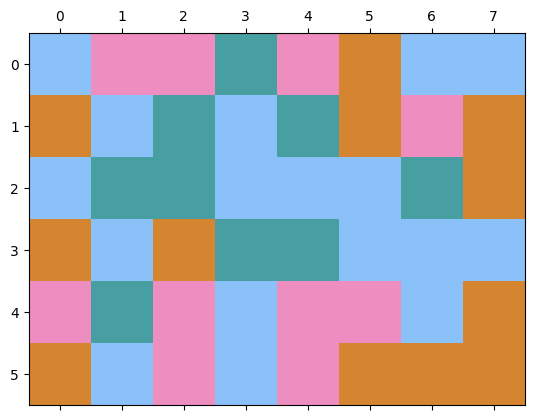

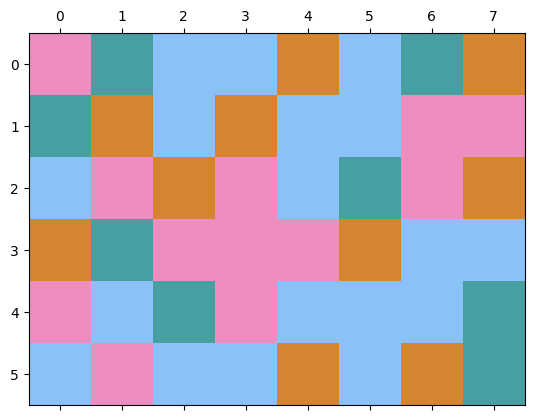

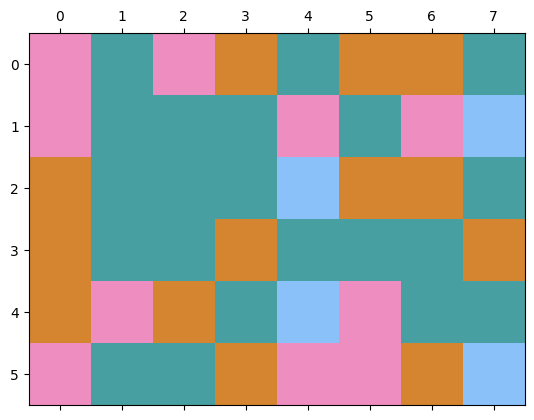

In [522]:
df7 = run_experiment(Condition.Identical, experiment_name="Identical_wasserstein", num_trials=100, metric="wasserstein")

In [395]:
ddf = pd.read_csv("Shifted_run3_fewer_anchors_df.csv")
ddf.mean()

Unnamed: 0                  25.500000
Accuracy (RR)               34.074615
Accuracy (permutation)       2.973462
Similarity (RR)              0.624670
Similarity (permutation)     0.689574
dtype: float64

In [329]:
df1 = pd.read_csv("camera_ready_results/Expansion_run1_df.csv")
df2 = pd.read_csv("camera_ready_results/Expansion_run2_df.csv")
df3 = pd.read_csv("camera_ready_results/Expansion_run3_df.csv")
df4 = pd.read_csv("camera_ready_results/Expansion_run4_df.csv")

In [330]:
df6 = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [332]:
df6.to_csv("Expansion_runs_accumulated.csv")

# Results

In [370]:
# Identical + baseline conditions

df = pd.read_csv("camera_ready_results/Landmark_run1_df.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df.head()

Accuracy (RR)  Accuracy (permutation)  Similarity (RR)  \
0          37.65                    17.4         0.558112   
1          25.00                     8.1         0.390983   
2          36.40                    15.6         0.536060   
3          42.45                    73.2         0.559819   
4          26.65                     2.5         0.514203   

   Similarity (permutation)  
0                  0.894146  
1                  0.891096  
2                  0.891035  
3                  0.896021  
4                  0.888177

In [371]:
df.mean()

Accuracy (RR)               34.129000
Accuracy (permutation)      20.703000
Similarity (RR)              0.521176
Similarity (permutation)     0.891348
dtype: float64

In [372]:
df.std()

Accuracy (RR)                6.470076
Accuracy (permutation)      19.143807
Similarity (RR)              0.061718
Similarity (permutation)     0.002545
dtype: float64

## Plot latent spaces

In [109]:
df3

Condition             Similar                                       \
thing               Identical                                        
thing2    Accuracy (baseline) Accuracy (permutation) Accuracy (RR)   
0                      0.0002                  25.68         89.43   
1                      0.0094                 100.00         90.76   

Condition                                                                 
thing                                                                     
thing2    Similarity (baseline) Similarity (permutation) Similarity (RR)  
0                tensor(0.0547)                 0.694690        0.987938  
1                tensor(0.0929)                 0.715859        0.989725

In [22]:
def _format_ax(ax, model_dict, model_type, idx, epsilon, num_classes, rep_type):
    ax.set_title(f"{model_type} {idx} {rep_type} representation")
    ax.tick_params(
        axis='both',          
        which='both',  
        bottom=False,  
        top=False,    
        left=False,
        labelleft=False,
        labelbottom=False)

def _plot_means(ax, model_dict, rep_type, epsilon, num_classes, model1_classes=None):
    abs_mean = model_dict[f'all_{rep_type[:3]}_mean']
    if model1_classes is not None:
        abs_mean = abs_mean[model1_classes]
    ax.scatter(abs_mean[:,0], abs_mean[:,1], color="black")
    numbers = model1_classes if model1_classes is not None else range(num_classes)
    [ax.annotate(text=n, xy=(abs_mean[idx,0] + epsilon, abs_mean[idx,1] + epsilon)) for idx, n in enumerate(numbers)]
    
def _get_rel_PCA(models_info, model_key, rtype, use_rel_PCA):
    return models_info[f'model{use_rel_PCA}']['rel_pca'] if use_rel_PCA is not None else models_info[model_key][f'{rtype}_pca']
    
def _add_reps(models_info, idx, rep_type, use_rel_PCA:int=None):
    model_dict = models_info[idx]
    rtype = rep_type[:3]
    model_dict[f'all_{rtype}'] = torch.cat([t for k, t in model_dict[rtype].items()])
    model_dict[f'{rtype}_pca'].fit(model_dict[f'all_{rtype}'])    
    pca_to_use = _get_rel_PCA(models_info, idx, rtype, use_rel_PCA)
    model_dict[f'all_{rtype}_mean'] = pca_to_use.transform(
        torch.cat([t.unsqueeze(0) for k, t in model_dict[f'{rtype}_mean'].items()])
    )
    return model_dict
  
def plot_latents(models, use_rel_PCA:int=0, num_classes:int=4, model_type='CSCG', abs_epsilon=0.01, rel_epsilon=.3, model1_classes=list(range(4))):

    num_models = len(models)
    models_info = {
        f'model{i}': {
            'model': models[i], 
            'abs_pca': PCA(n_components=2),
            'rel_pca': PCA(n_components=2),
            'abs': dict(),
            'rel': dict(),
            'abs_mean': dict(),
            'rel_mean': dict(),
            'mess_fwd': models[i].mess_fwd,
            'obs_seq': models[i].obs_seq,
            'anchors': models[i].anchors
        }
        for i in range(len(models))
    }

    fig, (abs_axs, rel_axs) = plt.subplots(2, num_models)

    for idx, (key, model_dict) in enumerate(models_info.items()):
        model_dict = models_info[key]
        for n in range(num_classes):
            n_idxs = model_dict['obs_seq'] == n
            model_dict['abs'][n] = model_dict['mess_fwd'][n_idxs]
            model_dict['abs_mean'][n] = torch.mean(model_dict['abs'][n], dim=0)
            model_dict['rel'][n] = get_RR(model_dict['abs'][n], model_dict['anchors'])
            model_dict['rel_mean'][n] = torch.mean(model_dict['rel'][n], dim=0)
            models_info[key] = model_dict

        models_info[key] = _add_reps(models_info, key, 'abs')
        models_info[key] = _add_reps(models_info, key, 'rel', 0)

        for n in range(num_classes):
            abs_rep_2d = models_info[key]['abs_pca'].transform(models_info[key]['abs'][n]) #[:100]
            abs_axs[idx].scatter(abs_rep_2d[:,0], abs_rep_2d[:,1])

            rel_pca = _get_rel_PCA(models_info, key, 'rel', use_rel_PCA)
            rel_rep_2d = rel_pca.transform(models_info[key]['rel'][n]) #[:100]
            rel_axs[idx].scatter(rel_rep_2d[:,0], rel_rep_2d[:,1])

        ax = abs_axs[idx]
        _format_ax(ax, model_dict, model_type, idx, abs_epsilon, num_classes, 'absolute')
        _plot_means(ax, model_dict, 'abs', abs_epsilon, num_classes, model1_classes if idx == 0 else None)
        ax = rel_axs[idx]
        _format_ax(ax, model_dict, model_type, idx, rel_epsilon, num_classes, 'relative')
        _plot_means(ax, model_dict, 'rel', rel_epsilon, num_classes, model1_classes if idx == 0 else None)

    fig.set_figwidth(10)
    fig.set_figheight(10)
                      

In [23]:
chmm1, chmm2 = add_anchors([chmm1, chmm2], x, permute=True)

# Use actions
# chmm1, chmm2 = add_anchors([chmm1, chmm2], x, a, permute=True)

## Plot representational similarity matrices

torch.Size([5000, 1000])
torch.Size([5000, 5000])


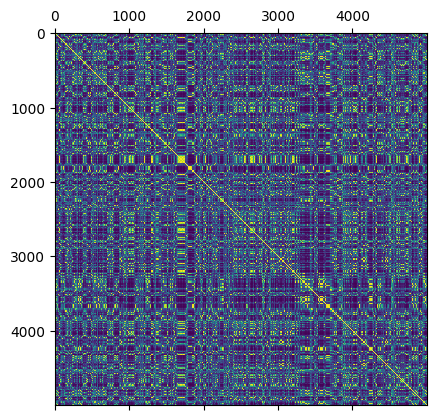

In [24]:
rr1 = get_RR(mess_fwd_chmm1x2, chmm1.anchors)
rr2 = get_RR(mess_fwd_chmm2x2, chmm2.anchors)
print(rr1.shape)
mat = cosine_sim(rr1, rr2, dim=None)
print(mat.shape)
plt.matshow(mat)

torch.Size([5000, 5000])
torch.Size([5000, 5000])


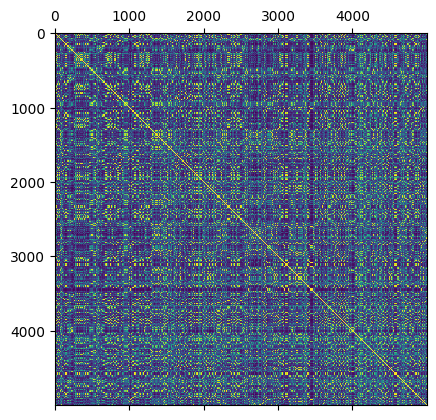

In [523]:
rr1 = get_RR(mess_fwd_chmm1x2, chmm1.anchors)
rr2 = get_RR(mess_fwd_chmm2x2, chmm2.anchors)
print(rr1.shape)
mat = cosine_sim(rr1, rr2, dim=None)
print(mat.shape)
plt.matshow(mat)

In [601]:
rrA = get_RR(mess_fwd_chmm1x2, mess_fwd_chmm1x2)
rrB = get_RR(mess_fwd_chmm2x2, mess_fwd_chmm2x2)
matt = cosine_sim(rrA, rrB, dim=None)

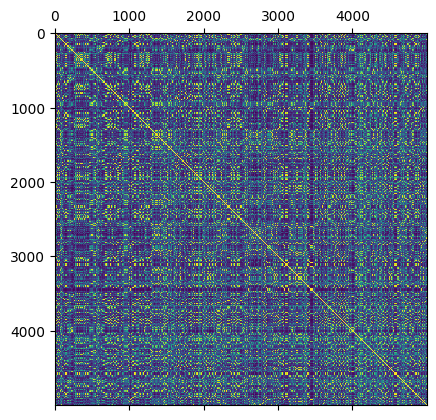

In [605]:
plt.matshow(mat)

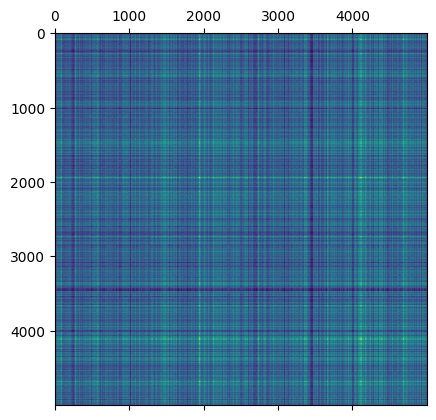

In [610]:
plt.matshow(cosine_sim(rr1, rrA, dim=None))

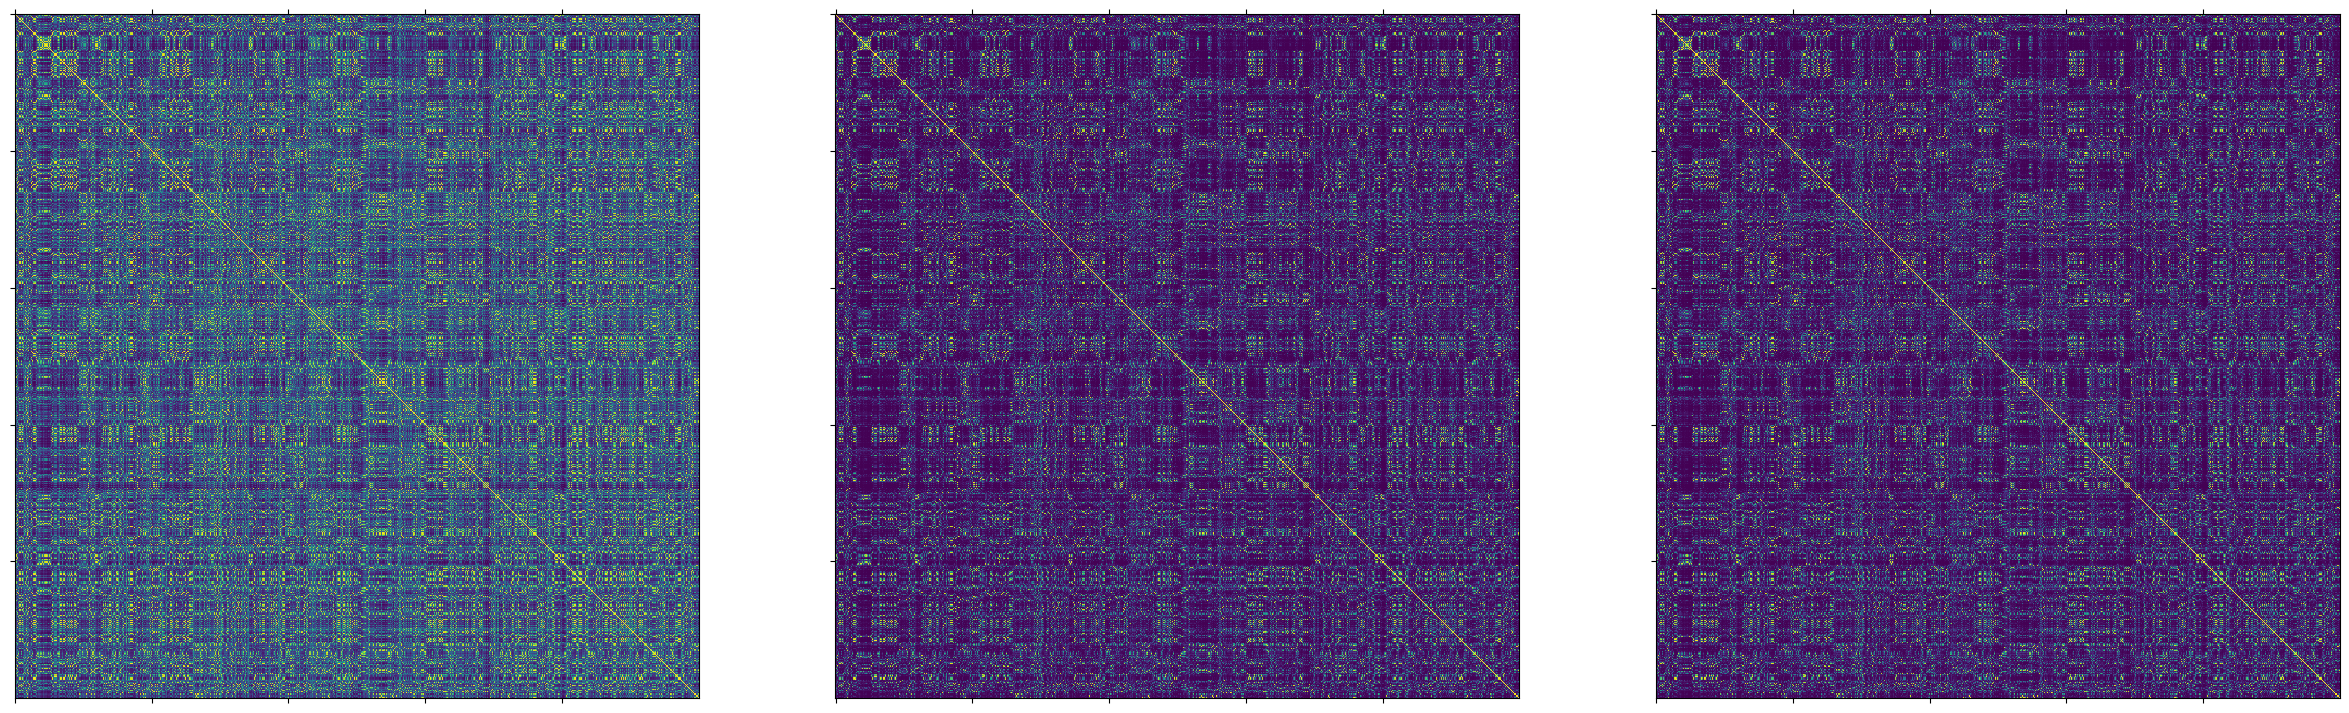

In [609]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(30)
fig.set_figheight(30)

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_yticks([])

ax[0].matshow(mat)
ax[1].matshow(rrA)
ax[2].matshow(rrB)

# for i in range(1,4):
#     # ax = plt.subplot(1, 3, i) # assign ax to that subplot
#     if i == 1:
#         ax[0].matshow(mat)
#     elif i == 2:
#         ax2.matshow(rrA)
#     elif i == 3:
#         ax3.matshow(rrB)
        
#     # ax.matshow(np.random.rand(10, 10)) # call plot method on that specific subplot


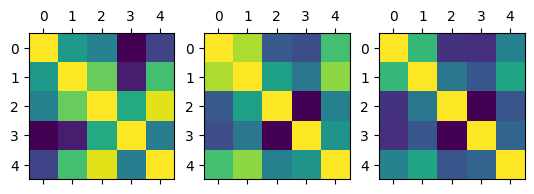

In [588]:
A = np.random.rand(5,10)
B = np.random.rand(5,10)

ab = cosine_sim(A,B,dim=None)
aa = cosine_sim(A,A,dim=None)
bb = cosine_sim(B,B,dim=None)


for i in range(1,4):
    ax = plt.subplot(1, 3, i) # assign ax to that subplot
    if i == 1:
        ax.matshow(cosine_sim(ab,ab,dim=None))
    elif i == 2:
        ax.matshow(cosine_sim(bb,bb,dim=None))
    elif i == 3:
        ax.matshow(cosine_sim(B,B,dim=None))
        
    # ax.matshow(np.random.rand(10, 10)) # call plot method on that specific subplot


In [583]:
cosine_sim(A,B, dim=0)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Test reconstruction accuracy

In [ ]:
anchor_Ns = [280, 500, 1000, 2000, 3000, 4000, 5000]

cosine_sims = []

for N in anchor_Ns:
    print(f"Performing reconstruction test with {N} anchors...")
    chmm1, chmm2 = add_anchors([chmm1, chmm2], x, num_anchors=N)
    mess_fwd_recon = reconstruct(mess_fwd_chmm1, chmm1.anchors, chmm2.anchors, return_softmax=False)
    cosine_sims.append(
        torch.mean(cosine_sim(mess_fwd_chmm2, mess_fwd_recon))
    )

Performing reconstruction test with 280 anchors...
Performing reconstruction test with 500 anchors...
Performing reconstruction test with 1000 anchors...
Performing reconstruction test with 2000 anchors...
Performing reconstruction test with 3000 anchors...
Performing reconstruction test with 4000 anchors...
Performing reconstruction test with 5000 anchors...


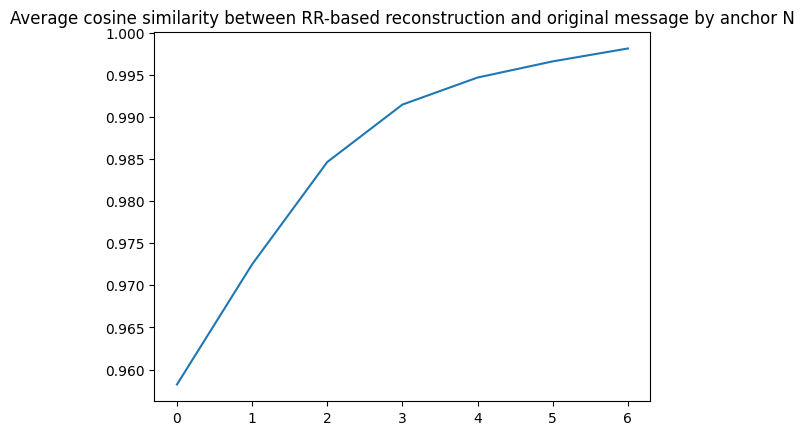

In [ ]:
plt.plot(range(len(cosine_sims)), cosine_sims)
plt.title("Average cosine similarity between message and RR-based reconstruction by anchor N")
plt.xlabel("Number of anchors")
plt.ylable("Cosine similarity")
# plt.xticks(anchor_Ns)
plt.show()

In [ ]:
mess_fwd_recon = reconstruct(mess_fwd_chmm1, chmm1.anchors, chmm2.anchors, return_softmax=False)

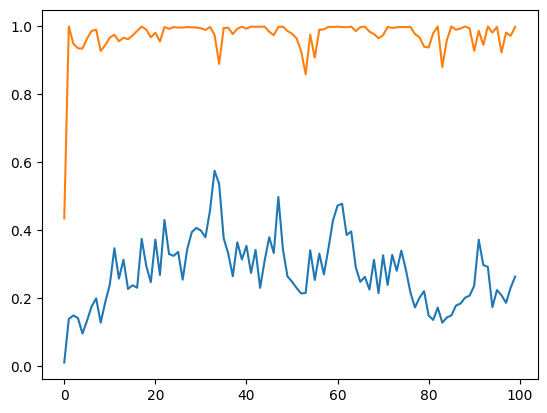

In [ ]:
# Plot accuracy of reconstruction over time

num_steps = 100

sequence = mess_fwd_chmm1[:num_steps]
similarities = cosine_sim(mess_fwd_chmm2, mess_fwd_recon,dim=-1)

mess_fwd_chmm1_actions[:num_steps]

plt.plot(
    range(num_steps),
    np.max(sequence, axis=1)
)
plt.plot(
    range(num_steps),
    similarities[:num_steps]
)

In [ ]:
chmm1_maxes = np.argmax(mess_fwd_chmm1,axis=1)
chmm2_maxes = np.argmax(mess_fwd_chmm2,axis=1)

chmm1, chmm2 = add_anchors([chmm1, chmm2], x, num_anchors=5000)
mess_fwd_recon = reconstruct(mess_fwd_chmm1, chmm1.anchors, chmm2.anchors, return_softmax=False)

rr_reconstructed_maxes = np.argmax(mess_fwd_recon,axis=1)

map_recon = np.array([state_map[s] for s in chmm1_maxes])

print("Accuracy using permutations: ", f"{sum(chmm2_maxes == map_recon)/len(mess_fwd_recon)*100}%")
print("Accuracy using RRs: ", f"{sum(chmm2_maxes == rr_reconstructed_maxes)/len(mess_fwd_recon)*100}%")

Accuracy using permutations:  99.98%
Accuracy using RRs:  96.3%


In [ ]:
mess_fwd_x2_recon = reconstruct(mess_fwd_chmm1x2, chmm1.anchors, chmm2.anchors, return_softmax=False)

rr_reconstructed_maxes_x2 = np.argmax(mess_fwd_x2_recon,axis=1)

chmm1_maxes_x2 = np.argmax(mess_fwd_chmm1x2,axis=1)
chmm2_maxes_x2 = np.argmax(mess_fwd_chmm2x2,axis=1)

map_recon_x2 = np.array([state_map[s] for s in chmm1_maxes_x2])

print("Accuracy using permutations (distinct test sequence): ", f"{sum(chmm2_maxes_x2 == map_recon_x2)/len(mess_fwd_x2_recon)*100}%")
print("Accuracy using RRs (distinct test sequence): ", f"{sum(chmm2_maxes_x2 == rr_reconstructed_maxes_x2)/len(mess_fwd_x2_recon)*100}%")


Accuracy using permutations (distinct test sequence):  99.98%
Accuracy using RRs (distinct test sequence):  88.48%


In [ ]:
# Accuracy of reconstruction over time

recon_map = np.array(
    [
        np.array([reconstruct_state(s1, s2, state_map) for (s1, s2) in zip(mess_fwd_chmm1x2_actions, mess_fwd_chmm2x2_actions)])    
    ]
)
print("Reconstruction using permutations: ", torch.mean(cosine_sim(mess_fwd_chmm2x2_actions, recon_map)))


similarities_1 = cosine_sim(mess_fwd_x2_recon_a, mess_fwd_chmm2x2_actions, dim=-1)
print("Cosine sim 1->2: ", torch.mean(similarities_1))


(5000,)
(5000, 280)
Reconstruction using permutations:  tensor(0.9571)
Cosine sim 1->2:  tensor(0.9996)


### Plot RRs

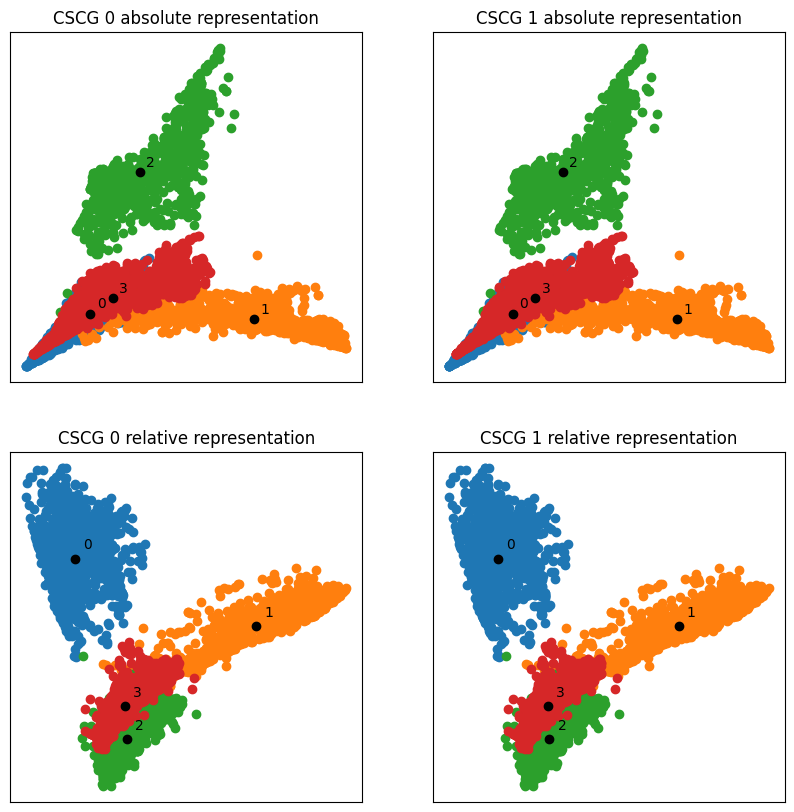

In [ ]:
plot_latents([chmm1, chmm2])

# Dissimilar rooms

### Expanded room

([], [])

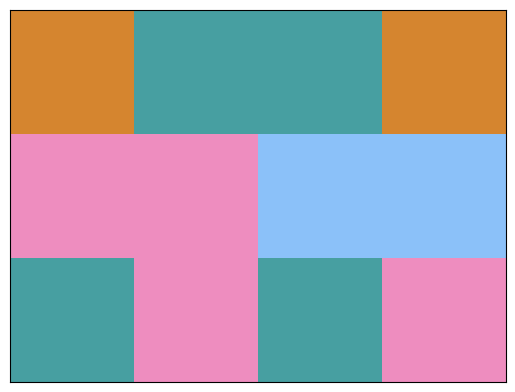

In [ ]:
small_room = np.random.choice(4, 3*4).reshape((3,4))
expanded_room = np.kron(small_room, np.ones((2,2), dtype='int'))


plt.matshow(small_room, cmap=cmap)
plt.xticks([])
plt.yticks([])

In [ ]:
# Train CSCGs on small/expanded rooms

a_s, x_s, rc_s = datagen_structured_obs_room(small_room, length=10000, seed=None)
a_e, x_e, rc_e = datagen_structured_obs_room(expanded_room, length=10000, seed=None)

n_clones = np.ones(n_emissions, dtype=np.int64) * 70

chmm_s = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_s, a=a_s, seed=None)
progression_s = chmm_s.learn_em_T(x_s, a_s, n_iter=1000)
chmm_e = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_e, a=a_e, seed=None)
progression_e = chmm_e.learn_em_T(x_e, a_e, n_iter=1000)

chmm_s.pseudocount = 0.0
v_prog_s = chmm_s.learn_viterbi_T(x_s, a_s, n_iter=100)
chmm_e.pseudocount = 0.0
v_prog_e = chmm_e.learn_viterbi_T(x_e, a_e, n_iter=100)

Average number of clones: 70.0


 60%|█████▉    | 596/1000 [05:43<03:52,  1.74it/s, train_bps=0.00456]

Average number of clones: 70.0



100%|██████████| 100/100 [00:28<00:00,  3.51it/s, train_bps=0.000813]


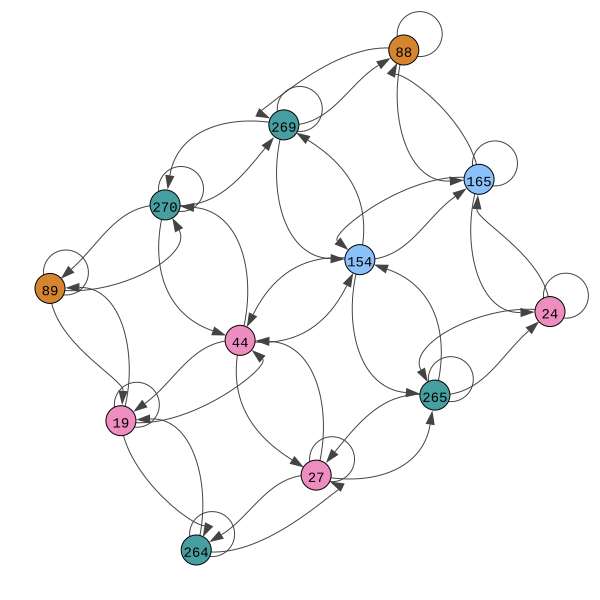

In [ ]:
graph = plot_graph(
    chmm_s, x_s, a_s, output_file="figures/small_room_graph.pdf", cmap=cmap
)
graph


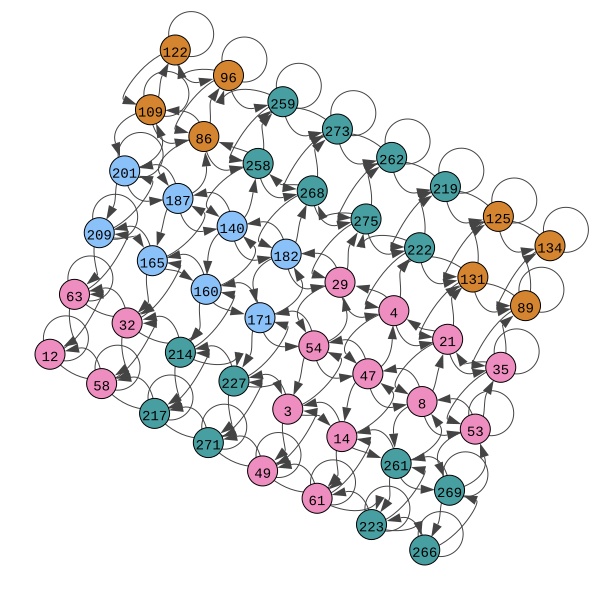

In [ ]:
graph = plot_graph(
    chmm_e, x_e, a_e, output_file="figures/expanded_room_graph.pdf", cmap=cmap
)
graph


In [ ]:
# Anchor sequences

act_seq_small, obs_seq_small, rc_small = datagen_structured_obs_room(
    small_room,
    start_r = 0,
    start_c = 0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=5000
)

act_seq_expanded = np.squeeze(np.kron(act_seq_small, np.ones((1,2), dtype='int'))) #[1:]

_, obs_seq_expanded, rc_expanded = datagen_structured_obs_room(
    expanded_room,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    actions=act_seq_expanded,
)


In [ ]:
# Test sequences

act_seq_small2, obs_seq_small2, rc_small2 = datagen_structured_obs_room(
    small_room,
    start_r = 0,
    start_c = 0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=5000,
    seed=None
)

act_seq_expanded2 = np.squeeze(np.kron(act_seq_small2, np.ones((1,2), dtype='int')))

_, obs_seq_expanded2, rc_expanded2 = datagen_structured_obs_room(
    expanded_room,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    seed=None,
    actions=act_seq_expanded2,
)


In [ ]:
s_mess_fwd = get_mess_fwd(chmm_s, obs_seq_small, act_seq_small, pseudocount_E=0.1)
e_mess_fwd = get_mess_fwd(chmm_e, obs_seq_expanded, act_seq_expanded, pseudocount_E=0.1)

s_mess_fwd2 = get_mess_fwd(chmm_s, obs_seq_small2, act_seq_small2, pseudocount_E=0.1)
e_mess_fwd2 = get_mess_fwd(chmm_e, obs_seq_expanded2, act_seq_expanded2, pseudocount_E=0.1)

e_mess_fwd_subsampled = e_mess_fwd[::2]

chmm_s.anchors = s_mess_fwd
chmm_e.anchors = e_mess_fwd_subsampled

In [ ]:
s_recon = reconstruct(chmm_e.anchors, chmm_e.anchors, chmm_s.anchors)
e_recon = reconstruct(s_mess_fwd, chmm_s.anchors, chmm_e.anchors)
similarities_s = cosine_sim(s_mess_fwd, s_recon, dim=-1)
similarities_e = cosine_sim(chmm_e.anchors, e_recon, dim=-1)

In [ ]:
s_maxes = np.argmax(s_mess_fwd,axis=1)
e_maxes = np.argmax(e_mess_fwd_subsampled,axis=1)

s_recon_maxes = np.argmax(s_recon,axis=1)
e_recon_maxes = np.argmax(e_recon,axis=1)

print("Accuracy translating across `small` and `expanded` room maps using RRs: ", f"{sum(s_maxes == s_recon_maxes)/len(s_maxes)*100}%")
print("Accuracy in reverse direction (expanded -> small): ", f"{sum(e_maxes == e_recon_maxes)/len(e_maxes)*100}%")

print("Average cosine similarity (small-room messages VS reconstruction)", torch.mean(cosine_sim(s_mess_fwd, s_recon)))
print("Average cosine similarity (large-room messages VS reconstruction)", torch.mean(cosine_sim(e_mess_fwd_subsampled, e_recon)))

Accuracy translating across `small` and `expanded` room maps using RRs:  87.83999999999999%
Accuracy in reverse direction (expanded -> small):  62.419999999999995%
Average cosine similarity (small-room messages VS reconstruction) tensor(0.9870)
Average cosine similarity (large-room messages VS reconstruction) tensor(0.9261)


In [ ]:
# Test

s2_maxes = np.argmax(s_mess_fwd2,axis=1)
e2_maxes = np.argmax(e_mess_fwd2[::2], axis=1)

e_mess_fwd2_subsampled = e_mess_fwd2[::2]

s2_recon = reconstruct(e_mess_fwd2_subsampled, chmm_e.anchors, chmm_s.anchors)
e2_recon = reconstruct(s_mess_fwd2, chmm_s.anchors, chmm_e.anchors)


s2_recon_maxes = np.argmax(s2_recon,axis=1)
e2_recon_maxes = np.argmax(e2_recon,axis=1)

print("Accuracy translating across `small` and `expanded` room maps using RRs: ", f"{sum(s2_maxes == s2_recon_maxes)/len(s2_maxes)*100}%")
print("Accuracy in reverse direction (expanded -> small): ", f"{sum(e2_maxes == e2_recon_maxes)/len(e2_maxes)*100}%")

Accuracy translating across `small` and `expanded` room maps using RRs:  86.4%
Accuracy in reverse direction (expanded -> small):  61.260000000000005%


In [ ]:
# Test w/precise beliefs

s_maxes = np.argmax(s_mess_fwd2,axis=1)
e_maxes = np.argmax(e_mess_fwd2_subsampled,axis=1)

s_recon_maxes = np.argmax(s_recon3,axis=1)
e_recon_maxes = np.argmax(e_recon3,axis=1)

print("Accuracy translating across `small` and `expanded` room maps using RRs: ", f"{sum(s_maxes == s_recon_maxes)/len(s_maxes)*100}%")
print("Accuracy in reverse direction (expanded -> small): ", f"{sum(e_maxes == e_recon_maxes)/len(e_maxes)*100}%")

# Average cosine similarity
print("Average cosine similarity (small-room messages VS reconstruction)", torch.mean(cosine_sim(s_mess_fwd2, s_recon3)))
print("Average cosine similarity (large-room messages VS reconstruction)", torch.mean(cosine_sim(e_mess_fwd_subsampled2, e_recon3)))

Accuracy translating across `small` and `expanded` room maps using RRs:  97.52%
Accuracy in reverse direction (expanded -> small):  48.78%
Average cosine similarity (small-room messages VS reconstruction) tensor(0.9768)
Average cosine similarity (large-room messages VS reconstruction) tensor(0.6070)


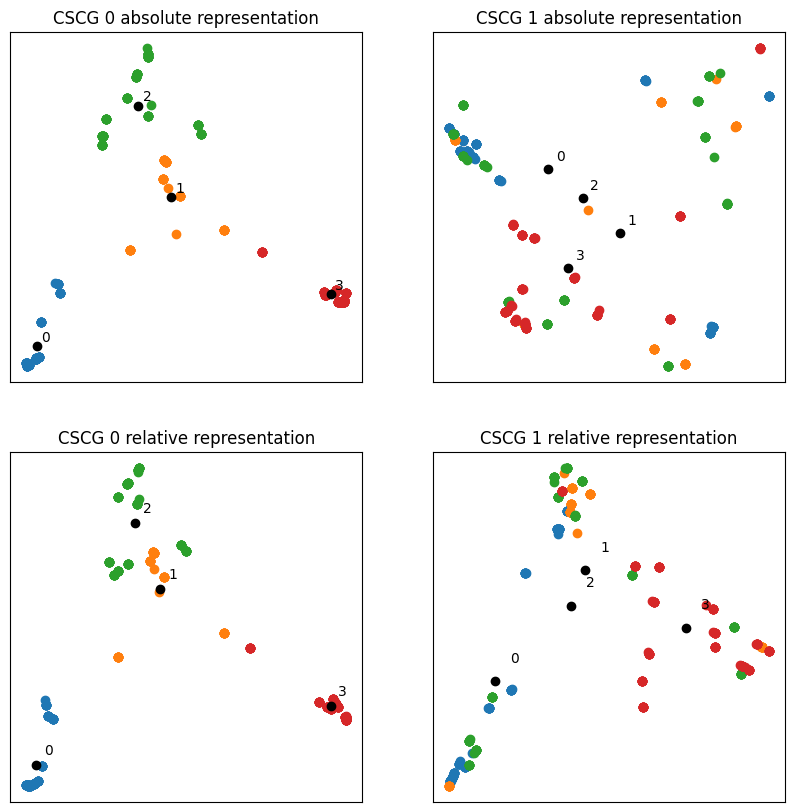

In [ ]:
# Try plotting
plot_latents([chmm_s, chmm_e])

### Shifted rooms

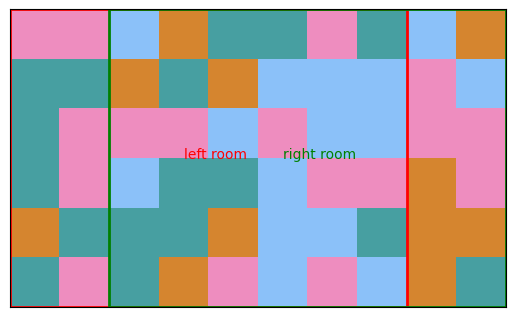

In [ ]:
big_room = np.random.choice(4, 6*10).reshape((6,10))
left_room = big_room[:, :8]
right_room = big_room[:, 2:]

fig, ax = plt.subplots()

_ = ax.matshow(big_room, cmap=cmap)
left_box = patches.Rectangle((-0.5, -0.5), 8, 6, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(left_box)
_ = ax.annotate("left room", (3, 2.5), color='red')

right_box = patches.Rectangle((2 -0.5, -0.5), 8, 6, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(right_box)
_ = ax.annotate("right room", (5, 2.5), color='green')
_ = ax.set_xticks([])
_ = ax.set_yticks([])


In [ ]:
# Train CSCGs on shifted rooms

a_l, x_l, rc_l = datagen_structured_obs_room(left_room, length=10000, seed=None)
a_r, x_r, rc_r = datagen_structured_obs_room(right_room, length=10000, seed=None)

n_clones = np.ones(n_emissions, dtype=np.int64) * 70

chmm_l = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_l, a=a_l, seed=None)
progression_l = chmm_l.learn_em_T(x_l, a_l, n_iter=1000)
chmm_r = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_r, a=a_r, seed=None)
progression_r = chmm_r.learn_em_T(x_r, a_r, n_iter=1000)

chmm_l.pseudocount = 0.0
v_prog_l = chmm_l.learn_viterbi_T(x_l, a_l, n_iter=100)
chmm_r.pseudocount = 0.0
v_prog_r = chmm_r.learn_viterbi_T(x_r, a_r, n_iter=100)

Average number of clones: 70.0


 12%|█▎        | 125/1000 [01:09<08:05,  1.80it/s, train_bps=0.0467]

Average number of clones: 70.0



100%|██████████| 100/100 [00:28<00:00,  3.54it/s, train_bps=0.000971]


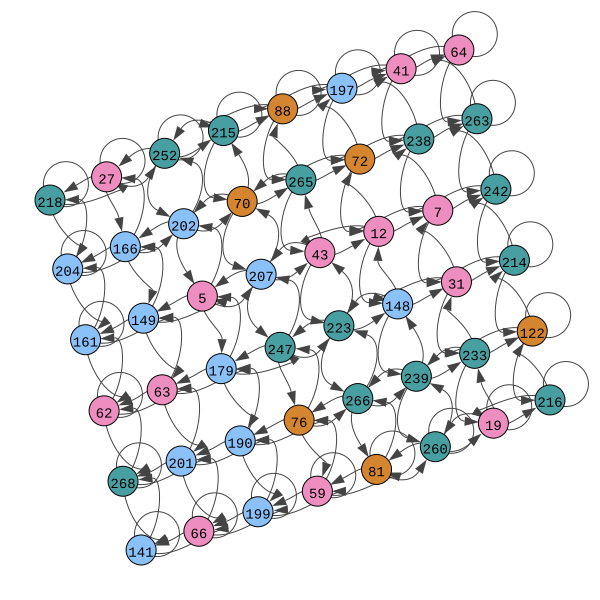

In [ ]:
graph = plot_graph(
    chmm_l, x_l, a_l, output_file="figures/left_room_graph.pdf", cmap=cmap
)
graph

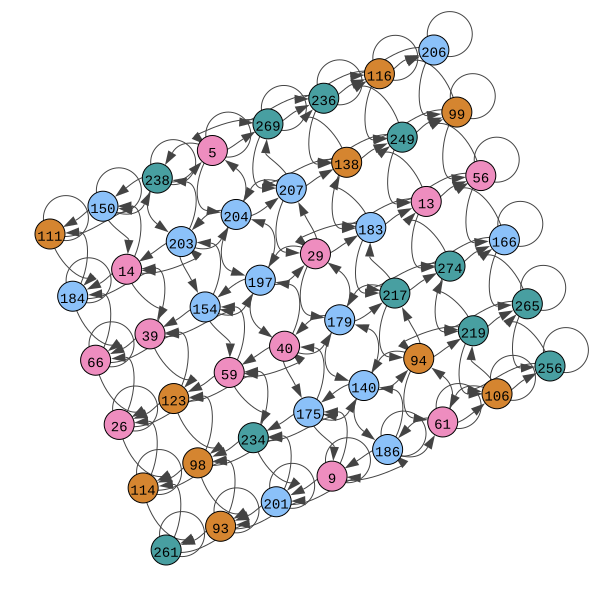

In [ ]:
graph = plot_graph(
    chmm_r, x_r, a_r, output_file="figures/right_room_graph.pdf", cmap=cmap
)
graph

In [ ]:
# Get anchor sequences
act_seq_l, obs_seq_l, rc_l = datagen_structured_obs_room(
    left_room,
    start_r = 0,
    start_c = 0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=5000,
    seed=None
)

act_seq_r, obs_seq_r, rc_r = datagen_structured_obs_room(
    right_room,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    seed=None,
    actions=act_seq_l,
)

# Test sequences
act_seq_l2, obs_seq_l2, rc_l2 = datagen_structured_obs_room(
    left_room,
    start_r = 0,
    start_c = 0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=5000,
    seed=None
)

act_seq_r2, obs_seq_r2, rc_r2 = datagen_structured_obs_room(
    right_room,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    seed=None,
    actions=act_seq_l2,
)


In [ ]:
chmm_l, chmm_r = add_anchors([chmm_l, chmm_r], [obs_seq_l, obs_seq_r], num_anchors=5000, permute=True)

l_mess_fwd = get_mess_fwd(chmm_l, obs_seq_l, pseudocount_E=0.1)
r_mess_fwd = get_mess_fwd(chmm_r, obs_seq_r, pseudocount_E=0.1)

l_mess_fwd2 = get_mess_fwd(chmm_l, obs_seq_l2, pseudocount_E=0.1)
r_mess_fwd2 = get_mess_fwd(chmm_r, obs_seq_r2, pseudocount_E=0.1)

l_mess_fwd_a = get_mess_fwd(chmm_l, obs_seq_l, act_seq_l, pseudocount_E=0.1)
r_mess_fwd_a = get_mess_fwd(chmm_r, obs_seq_r, act_seq_r, pseudocount_E=0.1)

l_mess_fwd2_a = get_mess_fwd(chmm_l, obs_seq_l2, act_seq_l2, pseudocount_E=0.1)
r_mess_fwd2_a = get_mess_fwd(chmm_r, obs_seq_r2, act_seq_r2, pseudocount_E=0.1)

In [ ]:
r_recon = reconstruct(l_mess_fwd, chmm_l.anchors, chmm_r.anchors)
l_recon = reconstruct(r_mess_fwd, chmm_r.anchors, chmm_l.anchors)

similarities_l = cosine_sim(l_mess_fwd, l_recon, dim=-1)
similarities_r = cosine_sim(r_mess_fwd, r_recon, dim=-1)

In [ ]:
act_l2, obs_l2, rc_l2 = datagen_structured_obs_room(
    left_room,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=10000,
)

act_r2, obs_r2, rc_r2 = datagen_structured_obs_room(
    right_room,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    actions = act_l2
)

l_mess_fwd2 = get_mess_fwd(chmm_l, obs_l2, pseudocount_E=0.1)
r_mess_fwd2 = get_mess_fwd(chmm_r, obs_r2, pseudocount_E=0.1)





In [ ]:
l_mess_fwd = get_mess_fwd(chmm_l, obs_seq_l, pseudocount_E=0.1)
r_mess_fwd = get_mess_fwd(chmm_r, obs_seq_r, pseudocount_E=0.1)

l_mess_fwd2 = get_mess_fwd(chmm_l, obs_seq_l2, pseudocount_E=0.1)
r_mess_fwd2 = get_mess_fwd(chmm_r, obs_seq_r2, pseudocount_E=0.1)


In [ ]:
r_recon = reconstruct(l_mess_fwd, chmm_l.anchors, chmm_r.anchors)
l_recon = reconstruct(r_mess_fwd, chmm_r.anchors, chmm_l.anchors)
r_recon2 = reconstruct(l_mess_fwd2, chmm_l.anchors, chmm_r.anchors)
l_recon2 = reconstruct(r_mess_fwd2, chmm_r.anchors, chmm_l.anchors)

l_maxes = np.argmax(l_mess_fwd,axis=1)
r_maxes = np.argmax(r_mess_fwd,axis=1)

l_recon_maxes = np.argmax(l_recon,axis=1)
r_recon_maxes = np.argmax(r_recon,axis=1)

l_maxes2 = np.argmax(l_mess_fwd2,axis=1)
r_maxes2 = np.argmax(r_mess_fwd2,axis=1)

l_recon_maxes2 = np.argmax(l_recon2,axis=1)
r_recon_maxes2 = np.argmax(r_recon2,axis=1)

print("Accuracy translating across `left` and `right` room maps using RRs (same anchors): ", f"{sum(l_maxes == l_recon_maxes)/len(l_maxes)*100}%")
print("Accuracy in reverse direction (right -> left) (same anchors): ", f"{sum(r_maxes == r_recon_maxes)/len(r_maxes)*100}%")

print("Accuracy translating across `left` and `right` room maps using RRs: ", f"{sum(l_maxes2 == l_recon_maxes2)/len(l_maxes2)*100}%")
print("Accuracy in reverse direction (right -> left): ", f"{sum(r_maxes2 == r_recon_maxes2)/len(r_maxes2)*100}%")

Accuracy translating across `left` and `right` room maps using RRs (same anchors):  4.32%
Accuracy in reverse direction (right -> left) (same anchors):  5.5%
Accuracy translating across `left` and `right` room maps using RRs:  3.56%
Accuracy in reverse direction (right -> left):  4.84%


In [ ]:
chmm_l, chmm_r = add_anchors([chmm_l, chmm_r], [obs_seq_l, obs_seq_r], [act_seq_l, act_seq_r], num_anchors=5000, permute=True)

r_recon_a = reconstruct(l_mess_fwd_a, chmm_l.anchors, chmm_r.anchors)
l_recon_a = reconstruct(r_mess_fwd_a, chmm_r.anchors, chmm_l.anchors)
r_recon2_a = reconstruct(l_mess_fwd2_a, chmm_l.anchors, chmm_r.anchors)
l_recon2_a = reconstruct(r_mess_fwd2_a, chmm_r.anchors, chmm_l.anchors)

l_maxes_a = np.argmax(l_mess_fwd_a,axis=1)
r_maxes_a = np.argmax(r_mess_fwd_a,axis=1)

l_recon_maxes_a = np.argmax(l_recon_a,axis=1)
r_recon_maxes_a = np.argmax(r_recon_a,axis=1)

l_maxes2_a = np.argmax(l_mess_fwd2_a,axis=1)
r_maxes2_a = np.argmax(r_mess_fwd2_a,axis=1)

l_recon_maxes2_a = np.argmax(l_recon2_a,axis=1)
r_recon_maxes2_a = np.argmax(r_recon2_a,axis=1)

print("Accuracy translating across `left` and `right` room maps using RRs (same anchors): ", f"{sum(l_maxes_a == l_recon_maxes_a)/len(l_maxes_a)*100}%")
print("Accuracy in reverse direction (right -> left) (same anchors): ", f"{sum(r_maxes_a == r_recon_maxes_a)/len(r_maxes_a)*100}%")

print("Accuracy translating across `left` and `right` room maps using RRs: ", f"{sum(l_maxes2_a == l_recon_maxes2_a)/len(l_maxes2_a)*100}%")
print("Accuracy in reverse direction (right -> left): ", f"{sum(r_maxes2_a == r_recon_maxes2_a)/len(r_maxes2_a)*100}%")

Accuracy translating across `left` and `right` room maps using RRs (same anchors):  100.0%
Accuracy in reverse direction (right -> left) (same anchors):  97.8%
Accuracy translating across `left` and `right` room maps using RRs:  99.94%
Accuracy in reverse direction (right -> left):  97.7%


In [ ]:
# Average cosine similarity
print("Average cosine similarity l -> r (imprecise; diff)", torch.mean(cosine_sim(l_mess_fwd2, l_recon2)))
print("Average cosine similarity r -> l", torch.mean(cosine_sim(r_mess_fwd2, r_recon2)))

print("Average cosine similarity l -> r (precise; diff)", torch.mean(cosine_sim(l_mess_fwd2_a, l_recon2_a)))
print("Average cosine similarity r -> l", torch.mean(cosine_sim(r_mess_fwd2_a, r_recon2_a)))

In [ ]:
# Average cosine similarity
print("Average cosine similarity (small-room messages VS reconstruction)", torch.mean(cosine_sim(l_mess_fwd, l_recon)))
print("Average cosine similarity (large-room messages VS reconstruction)", torch.mean(cosine_sim(r_mess_fwd, r_recon)))

Average cosine similarity (small-room messages VS reconstruction) tensor(0.9651)
Average cosine similarity (large-room messages VS reconstruction) tensor(0.9400)


In [ ]:
# Since the rooms are the same size, we can try the permutation method
l_sorted_indices = np.argsort(l_mess_fwd)[-1]
r_sorted_indices = np.argsort(r_mess_fwd)[-1]

lr_state_map = {s1: s2 for (s1, s2) in zip(l_sorted_indices, r_sorted_indices)}

l_maxes = np.argmax(l_mess_fwd,axis=1)
r_maxes = np.argmax(r_mess_fwd,axis=1)

r_map_recon = np.array([lr_state_map[s] for s in l_maxes])

print("Mapping accuracy using permutations: ", f"{sum(r_maxes == r_map_recon)/len(r_mess_fwd)*100}%")

# Permuted cosine similarity
l_mess_fwd_permuted = [sorted(t) for t in l_mess_fwd]
r_mess_fwd_permuted = [sorted(t) for t in r_mess_fwd]

print("Cosine sim using permutations: ", torch.mean(cosine_sim(l_mess_fwd_permuted, r_mess_fwd_permuted)))

Mapping accuracy using permutations:  1.96%
Cosine sim using permutations:  tensor(0.9115)


In [ ]:
r_recon_perm = np.array(
    [
        np.array([reconstruct_state(s1, s2, lr_state_map) for (s1, s2) in zip(l_mess_fwd, r_mess_fwd)])    
    ]
)

torch.mean(cosine_sim(r_mess_fwd, r_recon_perm))

tensor(0.9028)

In [ ]:
# Average cosine similarity
print("Average cosine similarity (small-room messages VS reconstruction)", torch.mean(cosine_sim(l_mess_fwd2, l_recon2)))
print("Average cosine similarity (large-room messages VS reconstruction)", torch.mean(cosine_sim(r_mess_fwd2, r_recon2)))

Average cosine similarity (small-room messages VS reconstruction) tensor(0.3794)
Average cosine similarity (large-room messages VS reconstruction) tensor(0.3188)


### Landmarks

In [ ]:
rand_room1 = np.random.choice(4, 6*8).reshape((6,8)).astype('int64')
rand_room2 = np.random.choice(4, 6*8).reshape((6,8)).astype('int64')

rand_room1[0] = rand_room2[0] = 8
rand_room1[-1] = rand_room2[-1] = 9
rand_room1[:, 0] = rand_room2[:, 0] = 10
rand_room1[:, -1] = rand_room2[:, -1] = 11
rand_room1[0, 0] = rand_room2[0, 0] = 4
rand_room1[0, -1] = rand_room2[0, -1] = 5
rand_room1[-1, 0] = rand_room2[-1, 0] = 6
rand_room1[-1, -1] = rand_room2[-1, -1] = 7

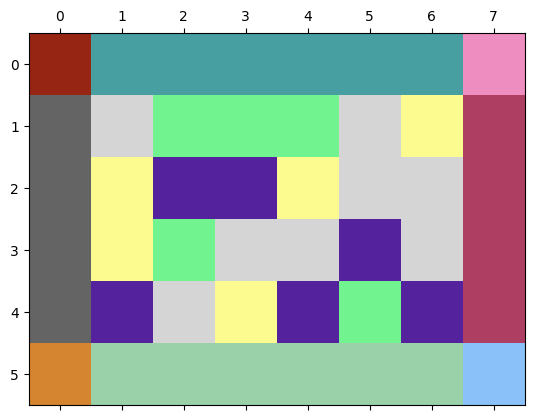

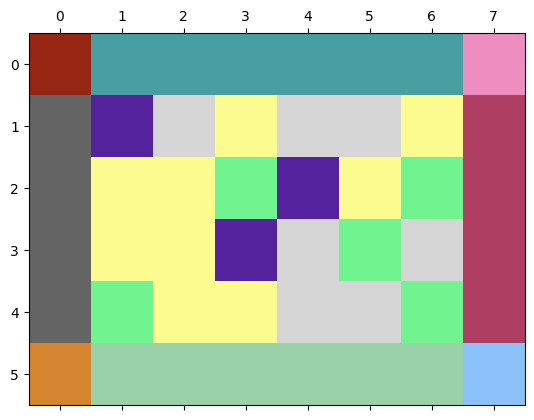

In [ ]:
custom_colors2 = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
            [155, 210, 170],
            [101, 101, 101],
            [175, 64, 100]
        ]
    )
    / 256
)
cmap2 = colors.ListedColormap(custom_colors2)
plt.matshow(rand_room1, cmap=cmap2)
plt.matshow(rand_room2, cmap=cmap2)

In [ ]:
border = np.ones((6, 8), dtype=int) * -1
border

border[0] = 8
border[-1] = 9
border[:, 0] = 10
border[:, -1] = 11
border[0, 0] = 4
border[0, -1] = 5
border[-1, 0] = 6
border[-1, -1] = 7

In [ ]:
n_emissions = rand_room1.max() + 1

a_rr1, x_rr1, rc_rr1 = datagen_structured_obs_room(rand_room1, length=10000)
a_rr2, x_rr2, rc_rr2 = datagen_structured_obs_room(rand_room2, length=10000)

n_clones = np.ones(n_emissions, dtype=np.int64) * 70
chmm_rr1 = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_rr1, a=a_rr1, seed=None)
progression = chmm_rr1.learn_em_T(x_rr1, a_rr1, n_iter=1000)
chmm_rr2 = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_rr1, a=a_rr1, seed=None)
progression = chmm_rr2.learn_em_T(x_rr2, a_rr2, n_iter=1000)

# refine learning
chmm_rr1.pseudocount = 0.0
chmm_rr1.learn_viterbi_T(x_rr1, a_rr1, n_iter=100)

chmm_rr2.pseudocount = 0.0
chmm_rr2.learn_viterbi_T(x_rr2, a_rr2, n_iter=100)

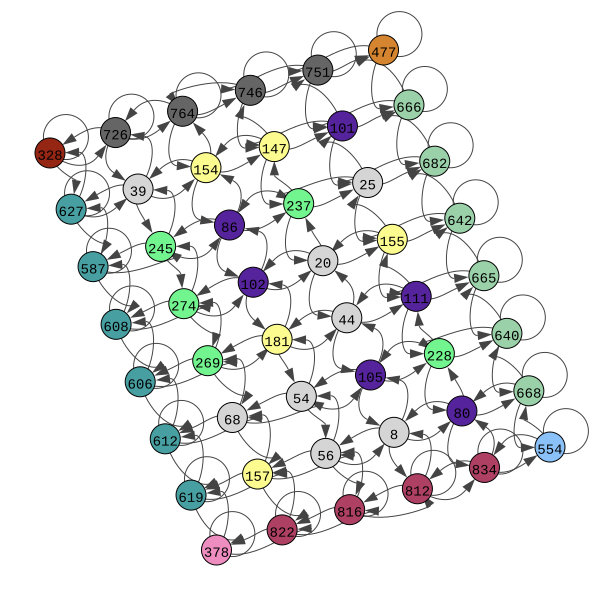

In [ ]:
graph = plot_graph(
    chmm_rr1, x_rr1, a_rr1, output_file="figures/rand_room_1_graph.pdf", cmap=cmap2
)
graph

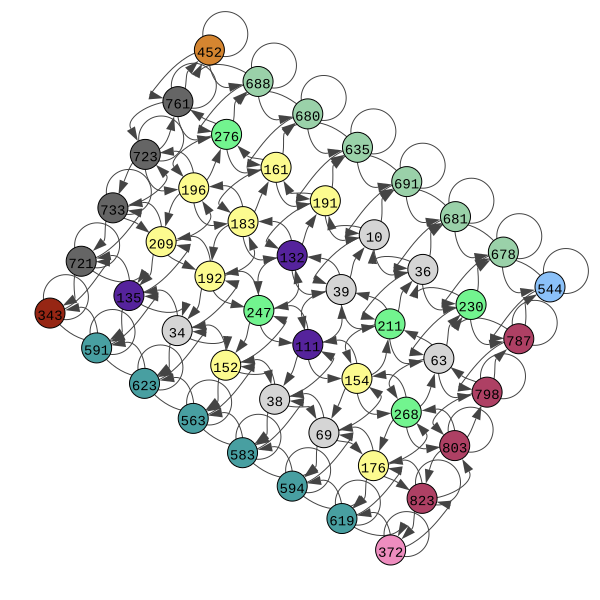

In [ ]:
graph = plot_graph(
    chmm_rr2, x_rr2, a_rr2, output_file="figures/rand_room_2_graph.pdf", cmap=cmap2
)
graph

In [ ]:
# Get limited set of border observations for anchors
b_a, b_o, b_rc = datagen_structured_obs_room(border, start_r=0, start_c=0, length=500, seed=None)
b_a3, b_o3, b_rc3 = datagen_structured_obs_room(rand_room1, start_r=0, start_c=0, length=500, seed=None)
b_a4, b_o4, b_rc4 = datagen_structured_obs_room(rand_room2, start_r=0, start_c=0, seed=None, length=None, actions=b_a3)


b_a2, b_o2, b_rc2 = datagen_structured_obs_room(
    border,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    seed=None,
    actions=b_a,
)

chmm_rr1, chmm_rr2 = add_anchors([chmm_rr1, chmm_rr2], [b_o, b_o2], num_anchors=500)


In [ ]:
# Plot accuracy of reconstruction over time

rr_mess_fwd1 = get_mess_fwd(chmm_rr1, b_o3, pseudocount_E=0.1)
rr_mess_fwd2 = get_mess_fwd(chmm_rr2, b_o4, pseudocount_E=0.1)

rr2_recon = reconstruct(rr_mess_fwd1, chmm_rr1.anchors, chmm_rr2.anchors)
rr1_recon = reconstruct(rr_mess_fwd2, chmm_rr2.anchors, chmm_rr1.anchors)
similarities_1 = cosine_sim(rr_mess_fwd1, rr1_recon, dim=-1)
similarities_2 = cosine_sim(rr_mess_fwd2, rr2_recon, dim=-1)

rr1_maxes = np.argmax(rr_mess_fwd1,axis=1)
rr2_maxes = np.argmax(rr_mess_fwd2,axis=1)

rr1_recon_maxes = np.argmax(rr1_recon,axis=1)
rr2_recon_maxes = np.argmax(rr2_recon,axis=1)

print("Accuracy translating 1 --> 2:", f"{sum(rr1_maxes == rr1_recon_maxes)/len(rr1_maxes)*100}%")
print("Accuracy translating 2 --> 1: ", f"{sum(rr2_maxes == rr2_recon_maxes)/len(rr2_maxes)*100}%")

# Average cosine similarity
print("Average cosine similarity (room 1 VS reconstruction)", torch.mean(cosine_sim(rr_mess_fwd1, rr1_recon)))
print("Average cosine similarity (room 2 VS reconstruction)", torch.mean(cosine_sim(rr_mess_fwd2, rr2_recon)))

Accuracy translating 1 --> 2: 35.0%
Accuracy translating 2 --> 1:  35.0%
Average cosine similarity (room 1 VS reconstruction) tensor(0.5203)
Average cosine similarity (room 2 VS reconstruction) tensor(0.5196)


In [ ]:
# Precise beliefs

chmm_rr1, chmm_rr2 = add_anchors([chmm_rr1, chmm_rr2], [b_o, b_o2], [b_a, b_a2], num_anchors=500)

# Plot accuracy of reconstruction over time

rr_mess_fwd1 = get_mess_fwd(chmm_rr1, b_o3, b_a3, pseudocount_E=0.1)
rr_mess_fwd2 = get_mess_fwd(chmm_rr2, b_o4, b_a4, pseudocount_E=0.1)

rr2_recon = reconstruct(rr_mess_fwd1, chmm_rr1.anchors, chmm_rr2.anchors)
rr1_recon = reconstruct(rr_mess_fwd2, chmm_rr2.anchors, chmm_rr1.anchors)
similarities_1 = cosine_sim(rr_mess_fwd1, rr1_recon, dim=-1)
similarities_2 = cosine_sim(rr_mess_fwd2, rr2_recon, dim=-1)

rr1_maxes = np.argmax(rr_mess_fwd1,axis=1)
rr2_maxes = np.argmax(rr_mess_fwd2,axis=1)

rr1_recon_maxes = np.argmax(rr1_recon,axis=1)
rr2_recon_maxes = np.argmax(rr2_recon,axis=1)

print("Accuracy translating 1 --> 2:", f"{sum(rr1_maxes == rr1_recon_maxes)/len(rr1_maxes)*100}%")
print("Accuracy translating 2 --> 1: ", f"{sum(rr2_maxes == rr2_recon_maxes)/len(rr2_maxes)*100}%")

# Average cosine similarity
print("Average cosine similarity (room 1 VS reconstruction)", torch.mean(cosine_sim(rr_mess_fwd1, rr1_recon)))
print("Average cosine similarity (room 2 VS reconstruction)", torch.mean(cosine_sim(rr_mess_fwd2, rr2_recon)))

Accuracy translating 1 --> 2: 100.0%
Accuracy translating 2 --> 1:  100.0%
Average cosine similarity (room 1 VS reconstruction) tensor(1.0000)
Average cosine similarity (room 2 VS reconstruction) tensor(1.0000)


[1 2]


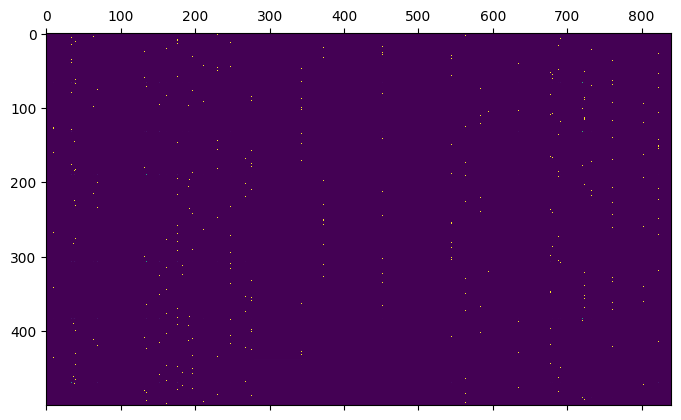

In [ ]:
# Visualize the RRs to get a sense of what's going on
def barplot(rep):
    plt.bar(range(len(rep)), rep)

rr2_recon[10][34]
print(b_rc3[10])
plt.matshow(chmm_rr2.anchors)

In [ ]:
# Since the rooms are the same size, we can try the permutation method
rr1_sorted_indices = np.argsort(rr_mess_fwd1)[-1]
rr2_sorted_indices = np.argsort(rr_mess_fwd2)[-1]

rr_state_map = {s1: s2 for (s1, s2) in zip(rr1_sorted_indices, rr2_sorted_indices)}

rr1_maxes = np.argmax(rr_mess_fwd1,axis=1)
rr2_maxes = np.argmax(rr_mess_fwd2,axis=1)

rr2_map_recon = np.array([rr_state_map[s] for s in rr1_maxes])

print("Mapping accuracy using permutations: ", f"{sum(rr2_maxes == rr2_map_recon)/len(rr_mess_fwd1)*100}%")

# Permuted cosine similarity
rr1_mess_fwd_permuted = [sorted(t) for t in rr_mess_fwd1]
rr2_mess_fwd_permuted = [sorted(t) for t in rr_mess_fwd2]

print("Cosine sim using permutations: ", torch.mean(cosine_sim(rr1_mess_fwd_permuted, rr2_mess_fwd_permuted)))

Mapping accuracy using permutations:  38.726790450928384%
Cosine sim using permutations:  tensor(0.9615)


In [ ]:
rr_recon_perm = np.array(
    [
        np.array([reconstruct_state(s1, s2, rr_state_map) for (s1, s2) in zip(rr_mess_fwd1, rr_mess_fwd2)])    
    ]
)

torch.mean(cosine_sim(rr_mess_fwd2, rr_recon_perm))

tensor(0.8878)

### Random rooms (no common landmarks)



In [ ]:
rand1 = np.random.choice(4, 6*8).reshape((6,8)).astype('int64')

# Use one more observation level for second room
rand2 = np.random.choice(5, 6*8).reshape((6,8)).astype('int64')

In [ ]:
n_emissions = rand1.max() + 1
n_emissions2 = rand2.max() + 1

a_rand1, x_rand1, rc_rand1 = datagen_structured_obs_room(rand1, length=10000)
a_rand2, x_rand2, rc_rand2 = datagen_structured_obs_room(rand2, length=10000)

n_clones = np.ones(n_emissions, dtype=np.int64) * 70
n_clones2 = np.ones(n_emissions2, dtype=np.int64) * 70

chmm_rand1 = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_rand1, a=a_rand1, seed=None)
_ = chmm_rand1.learn_em_T(x_rand1, a_rand1, n_iter=1000)
chmm_rand2 = CHMM(n_clones=n_clones2, pseudocount=2e-3, x=x_rand2, a=a_rand2, seed=None)
_ = chmm_rand2.learn_em_T(x_rand2, a_rand2, n_iter=1000)

# refine learning
chmm_rand1.pseudocount = 0.0
chmm_rand1.learn_viterbi_T(x_rand1, a_rand1, n_iter=100)

chmm_rand2.pseudocount = 0.0
chmm_rand2.learn_viterbi_T(x_rand2, a_rand2, n_iter=100)

cmap = colors.ListedColormap(custom_colors[-4:])
cmap2 = colors.ListedColormap(custom_colors[-5:])


Average number of clones: 70.0


 30%|██▉       | 299/1000 [03:10<07:27,  1.57it/s, train_bps=0.0161]

Average number of clones: 70.0



100%|██████████| 100/100 [00:30<00:00,  3.33it/s, train_bps=0.000845]


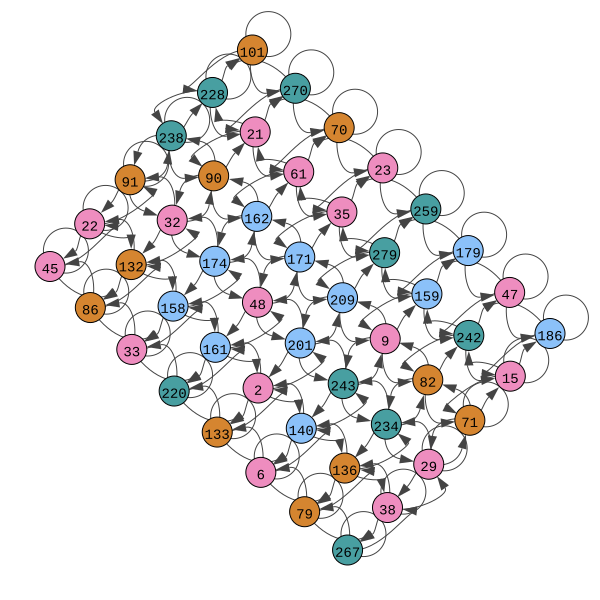

In [ ]:
graph = plot_graph(
    chmm_rand1, x_rand1, a_rand1, output_file="figures/rand_1_graph.pdf", cmap=cmap
)
graph

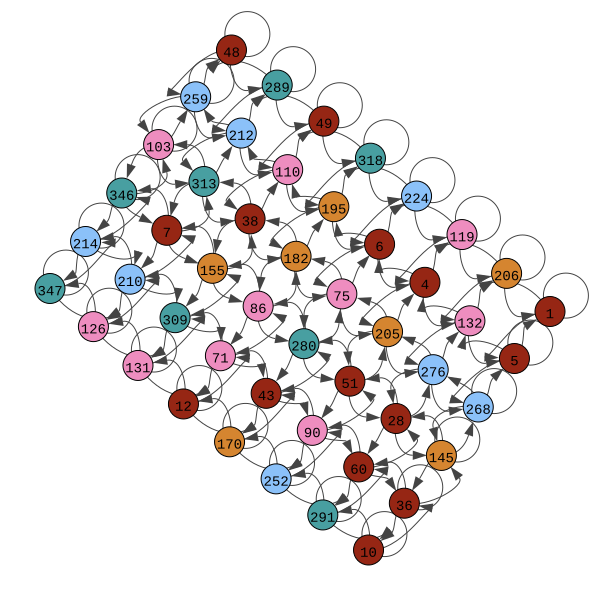

In [ ]:
graph = plot_graph(
    chmm_rand2, x_rand2, a_rand2, output_file="figures/rand_2_graph.pdf", cmap=cmap2, n_clones=n_clones2
)
graph

In [ ]:
obs_sequence_1, act_sequence_1 = snake_path(rand1, traverse_vertical=True, epochs=4)
obs_sequence_2, act_sequence_2 = snake_path(rand2, traverse_vertical=True, epochs=4)

mess_fwd_1 = get_mess_fwd(chmm_rand1, obs_sequence_1, pseudocount_E=0.1)
mess_fwd_2 = get_mess_fwd(chmm_rand2, obs_sequence_2, pseudocount_E=0.1)

chmm_rand1.anchors = np.array(mess_fwd_1)
chmm_rand1.mess_fwd = torch.Tensor(mess_fwd_1)
chmm_rand2.anchors = np.array(mess_fwd_2)
chmm_rand2.mess_fwd = torch.Tensor(mess_fwd_2)

chmm_rand1.obs_seq = obs_sequence_1
chmm_rand2.obs_seq = obs_sequence_2

In [ ]:
# Accuracy of reconstruction over time

recon_2 = reconstruct(mess_fwd_1, chmm_rand1.anchors, chmm_rand2.anchors)
recon_1 = reconstruct(mess_fwd_2, chmm_rand2.anchors, chmm_rand1.anchors)

similarities_1 = cosine_sim(mess_fwd_1, recon_1, dim=-1)
similarities_2 = cosine_sim(mess_fwd_2, recon_2, dim=-1)

print("Cosine sim 1->2: ", torch.mean(similarities_1))
print("Cosine sim 2->1: ", torch.mean(similarities_2))

Cosine sim 1->2:  tensor(0.9989)
Cosine sim 2->1:  tensor(0.9973)


In [ ]:
maxes_1 = np.argmax(mess_fwd_1,axis=1)
maxes_2 = np.argmax(mess_fwd_2,axis=1)

recon_maxes_1 = np.argmax(recon_1,axis=1)
recon_maxes_2 = np.argmax(recon_2,axis=1)

print("Accuracy recovering max belief 1->2: ", f"{sum(maxes_1 == recon_maxes_1)/len(maxes_1)*100}%")
print("Accuracy recovering max belief 2->1: ", f"{sum(maxes_2 == recon_maxes_2)/len(maxes_2)*100}%")

Accuracy recovering max belief 1->2:  99.33598937583001%
Accuracy recovering max belief 2->1:  99.46879150066401%


In [ ]:
# Add anchors
a_rand1, x_rand1, rc_rand1 = datagen_structured_obs_room(rand1, length=10000, seed=None)

a_rand2, x_rand2, rc_rand2 = datagen_structured_obs_room(
    rand2,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    seed=None,
    actions=a_rand1,
)

chmm_rand1, chmm_rand2 = add_anchors([chmm_rand1, chmm_rand2], [x_rand1, x_rand2], [a_rand1, a_rand2], num_anchors=5000)


a_rand12, x_rand12, rc_rand12 = datagen_structured_obs_room(rand1, length=10000, seed=None)

a_rand22, x_rand22, rc_rand22 = datagen_structured_obs_room(
    rand2,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    seed=None,
    actions=a_rand12,
)



In [ ]:
# Use actions to get mess_fwd
mess_fwd_12 = get_mess_fwd(chmm_rand1, x_rand12, a_rand12, pseudocount_E=0.1)
mess_fwd_22 = get_mess_fwd(chmm_rand2, x_rand22, a_rand22, pseudocount_E=0.1)

# Don't use actions to get mess_fwd
# mess_fwd_12 = get_mess_fwd(chmm_rand1, x_rand12, pseudocount_E=0.1)
# mess_fwd_22 = get_mess_fwd(chmm_rand2, x_rand22, pseudocount_E=0.1)

In [ ]:
# Accuracy of reconstruction over time (random path anchors)

recon_22 = reconstruct(mess_fwd_12, chmm_rand1.anchors, chmm_rand2.anchors)
recon_12 = reconstruct(mess_fwd_22, chmm_rand2.anchors, chmm_rand1.anchors)

similarities_12 = cosine_sim(mess_fwd_12, recon_12, dim=-1)
similarities_22 = cosine_sim(mess_fwd_22, recon_22, dim=-1)

print("Cosine sim 1->2: ", torch.mean(similarities_12))
print("Cosine sim 2->1: ", torch.mean(similarities_22))

Cosine sim 1->2:  tensor(0.9968)
Cosine sim 2->1:  tensor(0.9967)


In [ ]:
# Accuracy of reconstruction over time (random path anchors / no actions)

recon_22 = reconstruct(mess_fwd_12, chmm_rand1.anchors, chmm_rand2.anchors)
recon_12 = reconstruct(mess_fwd_22, chmm_rand2.anchors, chmm_rand1.anchors)

similarities_12 = cosine_sim(mess_fwd_12, recon_12, dim=-1)
similarities_22 = cosine_sim(mess_fwd_22, recon_22, dim=-1)

print("Cosine sim 1->2: ", torch.mean(similarities_12))
print("Cosine sim 2->1: ", torch.mean(similarities_22))

# with 5000 random anchors from a message generated w/o knowledge of actions
maxes_12 = np.argmax(mess_fwd_12,axis=1)
maxes_22 = np.argmax(mess_fwd_22,axis=1)

recon_maxes_12 = np.argmax(recon_12,axis=1)
recon_maxes_22 = np.argmax(recon_22,axis=1)

print("Accuracy recovering max belief 1->2: ", f"{sum(maxes_12 == recon_maxes_12)/len(maxes_12)*100}%")
print("Accuracy recovering max belief 2->1: ", f"{sum(maxes_22 == recon_maxes_22)/len(maxes_22)*100}%")

Cosine sim 1->2:  tensor(0.9984)
Cosine sim 2->1:  tensor(0.9983)
Accuracy recovering max belief 1->2:  99.83%
Accuracy recovering max belief 2->1:  99.83%


In [ ]:
# Accuracy of reconstruction over time (different # of obs levels)

recon_22 = reconstruct(mess_fwd_12, chmm_rand1.anchors, chmm_rand2.anchors)
recon_12 = reconstruct(mess_fwd_22, chmm_rand2.anchors, chmm_rand1.anchors)

similarities_12 = cosine_sim(mess_fwd_12, recon_12, dim=-1)
similarities_22 = cosine_sim(mess_fwd_22, recon_22, dim=-1)

print("Cosine sim 1->2: ", torch.mean(similarities_12))
print("Cosine sim 2->1: ", torch.mean(similarities_22))

# with 5000 random anchors from a message generated w/o knowledge of actions
maxes_12 = np.argmax(mess_fwd_12,axis=1)
maxes_22 = np.argmax(mess_fwd_22,axis=1)

recon_maxes_12 = np.argmax(recon_12,axis=1)
recon_maxes_22 = np.argmax(recon_22,axis=1)

print("Accuracy recovering max belief 1->2: ", f"{sum(maxes_12 == recon_maxes_12)/len(maxes_12)*100}%")
print("Accuracy recovering max belief 2->1: ", f"{sum(maxes_22 == recon_maxes_22)/len(maxes_22)*100}%")

Cosine sim 1->2:  tensor(0.9972)
Cosine sim 2->1:  tensor(0.9972)
Accuracy recovering max belief 1->2:  99.72%
Accuracy recovering max belief 2->1:  99.72%
